# Microsoft Base Phi Variante via Huggingface für Dropout

Für Microsoft Phi prompts so abändern, das alles in einer Message

In [ ]:

from dependencies.basic_functions import *
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
from datasets import load_dataset
import re
import seaborn as sns
import pickle



from huggingface_hub import login

login("")


import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

torch.random.manual_seed(0)

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-medium-4k-instruct", 
    device_map="cuda", 
    torch_dtype="auto", 
    trust_remote_code=True, 
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-medium-4k-instruct")

In [5]:
batch_size = 4

generation_args = {
    "max_new_tokens": 8,
    "return_full_text": False,
    #"temperature": 0.3,
    "do_sample": False,
}


def phi_inference(prompt,pipe,batch_size):
    clean_response_list = []
    for idx in tqdm(range(0, len(prompt), batch_size)):
        messages = prompt[idx:idx + batch_size]

        
        outputs = pipe(messages, **generation_args)

        for output in outputs:
            clean_response_list.append(output[0]['generated_text'])
    
    return np.array(clean_response_list)

from collections import Counter
# Define a function to compute the most common value and its frequency
def most_common_and_frequency(arr, axis=1):
    def mode_func(x):
        counter = Counter(x)
        most_common_value, frequency = counter.most_common(1)[0]
        return most_common_value, frequency
    
    # Apply along the specified axis
    results = np.apply_along_axis(lambda x: mode_func(x), axis=axis, arr=arr)
    most_common_values = np.array([r[0] for r in results])
    frequencies = np.array([r[1] for r in results])
    return most_common_values, frequencies.astype(int)


def enable_dropout(model,dropout_rate):
    for layer in model.modules():
        if isinstance(layer, nn.Dropout):
            layer.p = dropout_rate
            layer.train()


def disable_dropout(model):
    for layer in model.modules():
        if isinstance(layer, nn.Dropout):
            layer.p = 0  # Set dropout probability to 0
            layer.eval()  # Switch the layer to evaluation mode

def phi_dropout(dataset,pipe,batch_size=4):
    dropout_results = []
    for i in range(10):
        arr = phi_inference(dataset,pipe,batch_size=4)
        dropout_results.append(arr)
    dropout_results_array = np.array(dropout_results).T  
    return dropout_results_array


def clean_dropout(dropout_results_array):
    dropout_results_clean = []
    for vals in dropout_results_array:
        clean_vals = []
        for val in vals:
            clean_vals.append(postprocessing(val))
    
        dropout_results_clean.append(clean_vals)
    return np.array(dropout_results_clean)

## WLNI

In [17]:


Dataset_name = "wnli"
task = Dataset_name

datasets = {}
datasets[task] = load_dataset("glue", task)

Dataset_name = "wnli"
def sentiment_prompt(split):
    prompt_dataset = []
    for s1,s2 in split:
        messages = [
            #{"role": "system", "content": "Based on a pair of sentences, you will determine if the second sentence is entailed by the first. ONLY Respond with 'Yes' or 'No'"},
            {"role": "user", "content":  f"Based on a pair of sentences, you will determine if the second sentence is entailed by the first. ONLY Respond with 'Yes' or 'No' - Sentence 1: '{s1}', Sentence 2: '{s2}'"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

input_data = list(zip(datasets[Dataset_name]["validation"]["sentence1"],datasets[Dataset_name]["validation"]["sentence2"]))
val_prompt = sentiment_prompt(input_data)

input_data = list(zip(datasets[Dataset_name]["train"]["sentence1"],datasets[Dataset_name]["train"]["sentence2"]))
train_prompt = sentiment_prompt(input_data)
prompt = {"train":train_prompt,"val":val_prompt}



In [9]:
disable_dropout(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)  

warmup = val_predictions = phi_inference(prompt["val"][:8],pipe,batch_size) # pipebulding dauert -verzerrt erste time bei infernece

start_time = time.perf_counter()
val_predictions = phi_inference(prompt["val"],pipe,batch_size)
MatchVectorTime_val = time.perf_counter() -start_time

start_time = time.perf_counter()
train_predictions = phi_inference(prompt["train"],pipe,batch_size)
MatchVectorTime_train = time.perf_counter() -start_time

100%|██████████| 159/159 [01:19<00:00,  1.99it/s]


In [12]:
label_dict = {
    0:"No",
    1:"Yes"
}
def postprocessing(txt):
    if txt in ["Yes","No"]:
        return txt
    else:
        txt = txt.strip()
        
        if "No." in txt or txt[:2]=="No":
            return "No"
        if "Yes." in txt or txt[:3]=="Yes":
            return "Yes"
        return txt[:8]


written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
val_predictions_clean = np.array([postprocessing(y) for y in val_predictions])
mv_val = np.array(val_predictions_clean) == written_label


written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
train_predictions_clean = np.array([postprocessing(y) for y in train_predictions])
mv_train = np.array(train_predictions_clean) == written_label


match_vector = {"train": mv_train,
                "val":mv_val}

match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_val}

match_vector_labels= {"train": datasets[Dataset_name]["train"]["label"],
                     "val": datasets[Dataset_name]["validation"]["label"]}

return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}

print(np.sum(mv_val)/len(mv_val),MatchVectorTime_val)
print(np.sum(mv_train)/len(mv_train),MatchVectorTime_train)



0.7887323943661971 7.593592775985599
0.84251968503937 79.82705134525895


### Dropout WLNI

In [75]:
enable_dropout(model,0.1)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

warmup = phi_dropout(prompt["val"][:4],pipe,batch_size=4)

start_time = time.perf_counter()
val_dropout_results = phi_dropout(prompt["val"],pipe,batch_size=4)
most_common_values, frequencies = most_common_and_frequency(clean_dropout(val_dropout_results), axis=1)
time_val_dropout = time.perf_counter() -start_time


  0%|          | 0/18 [00:00<?, ?it/s]/home/chfa303b/.local/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.3` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 18/18 [00:08<00:00,  2.14it/s]


In [76]:
#most_common_values, frequencies
#"agreement_mv":agreement,"agreement_dp":agreement_dp bilden

written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
mv_val_dropout = most_common_values == written_label
agreement_mv = cov_acc_df_creator(frequencies/10,mv_val)
agreement_dp = cov_acc_df_creator(frequencies/10,mv_val_dropout)
agreement_mv["accuracy_coverage"]["test_time"] = time_val_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_val_dropout
return_dict["agreement_mv"] = agreement_mv
return_dict["agreement_dp"] = agreement_dp
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout)/len(mv_val_dropout))

In [77]:
print(np.sum(mv_val_dropout)/len(mv_val_dropout)) #0.704 bei 0.1 dropout ~12% schlechter als default

0.7605633802816901


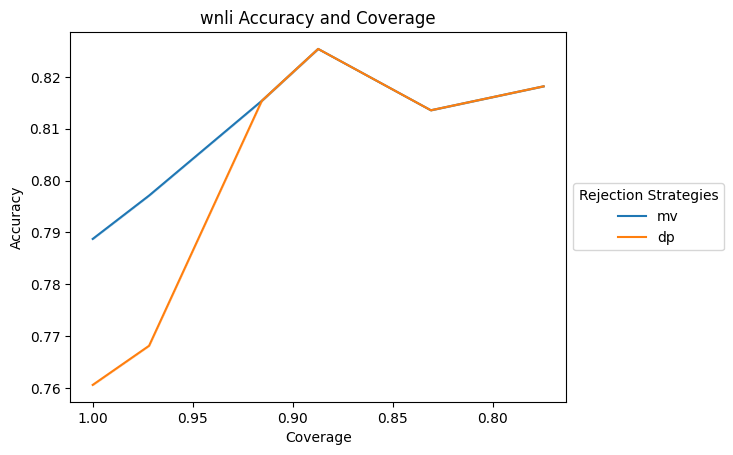

In [78]:

sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(agreement_mv["accuracy_coverage"]), label="mv")
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(agreement_dp["accuracy_coverage"]), label="dp")
plt.legend(title="Rejection Strategies", loc='center left', bbox_to_anchor=(1, 0.5))

# Set labels
plt.xlabel('Coverage')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()
plt.title(f'{Dataset_name} Accuracy and Coverage')
plt.show()

In [70]:
import pickle
dataset_name = "Base_Phi_GLUE_WNLI"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

## Cola 

In [20]:
Dataset_name = "cola"
task = Dataset_name

datasets = {}
datasets[task] = load_dataset("glue", task)


def sentiment_prompt(split):
    prompt_dataset = []
    for text in split:
        messages = [
            #{"role": "system", "content": "Is the following sentence grammatically correct? ONLY Respond with 'Yes' if correct and 'No' if not. "},
            {"role": "user", "content": f"Is the following sentence grammatically correct? ONLY Respond with 'Yes' if correct and 'No' if not. Sentence: {text}"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

#input_data = list(zip(datasets[Dataset_name]["test"]["sentence1"],datasets["mrpc"]["test"]["sentence2"]))
#test_prompt = sentiment_prompt(datasets["mrpc"]["test"]["sentence"])

val_prompt = sentiment_prompt(datasets[Dataset_name]["validation"]["sentence"])
train_prompt = sentiment_prompt(datasets[Dataset_name]["train"]["sentence"])

#prompt = {"train":train_prompt,"test":test_prompt, "val":val_prompt}
prompt = {"train":train_prompt,"val":val_prompt}

In [24]:
disable_dropout(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)  


warmup =  phi_inference(prompt["val"][:8],pipe,batch_size) # pipebulding dauert -verzerrt erste time bei infernece

start_time = time.perf_counter()
val_predictions = phi_inference(prompt["val"],pipe,batch_size)
MatchVectorTime_val = time.perf_counter() -start_time


start_time = time.perf_counter()
train_predictions = phi_inference(prompt["train"],pipe,batch_size)
MatchVectorTime_train = time.perf_counter() -start_time


100%|██████████| 2138/2138 [19:14<00:00,  1.85it/s]


In [26]:
label_dict = {
    0:"No",
    1:"Yes"
}
def postprocessing(txt):
    if txt in ["Yes","No"]:
        return txt
    else:
        txt = txt.strip()
        
        if "No." in txt or txt[:2]=="No":
            return "No"
        if "Yes." in txt or txt[:3]=="Yes":
            return "Yes"
        return txt[:8]


written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
val_predictions_clean = np.array([postprocessing(y) for y in val_predictions])
mv_val = np.array(val_predictions_clean) == written_label

written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
train_predictions_clean = np.array([postprocessing(y) for y in train_predictions])
mv_train = np.array(train_predictions_clean) == written_label


match_vector = {"train": mv_train,
                "val":mv_val}

match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_val}

match_vector_labels= {"train": datasets[Dataset_name]["train"]["label"],
                     "val": datasets[Dataset_name]["validation"]["label"]}

return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}

print(np.sum(mv_val)/len(mv_val),MatchVectorTime_val)
print(np.sum(mv_train)/len(mv_train),MatchVectorTime_train)

0.7746883988494727 143.96298928186297
0.7882119050403461 1154.7469523698092


### Dropout Cola

In [28]:
enable_dropout(model,0.1)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

warmup = phi_dropout(prompt["val"][:4],pipe,batch_size=4)

start_time = time.perf_counter()
val_dropout_results = phi_dropout(prompt["val"],pipe,batch_size=4)
most_common_values, frequencies = most_common_and_frequency(clean_dropout(val_dropout_results), axis=1)
time_val_dropout = time.perf_counter() -start_time


100%|██████████| 261/261 [03:10<00:00,  1.37it/s]


In [29]:
written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
mv_val_dropout = most_common_values == written_label
agreement_mv = cov_acc_df_creator(frequencies/10,mv_val)
agreement_dp = cov_acc_df_creator(frequencies/10,mv_val_dropout)
agreement_mv["accuracy_coverage"]["test_time"] = time_val_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_val_dropout
return_dict["agreement_mv"] = agreement_mv
return_dict["agreement_dp"] = agreement_dp
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout)/len(mv_val_dropout))

0.7516778523489933


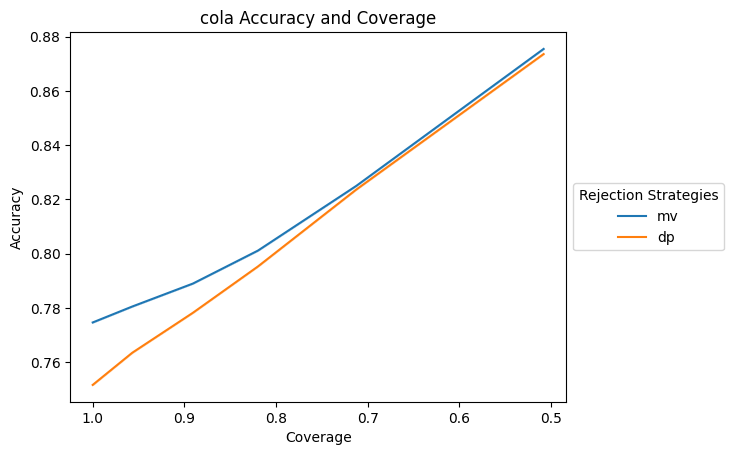

dict_keys(['match_vector', 'match_vector_time', 'prompt', 'match_vector_labels', 'agreement_mv', 'agreement_dp'])


In [31]:
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(agreement_mv["accuracy_coverage"]), label="mv")
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(agreement_dp["accuracy_coverage"]), label="dp")
plt.legend(title="Rejection Strategies", loc='center left', bbox_to_anchor=(1, 0.5))

# Set labels
plt.xlabel('Coverage')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()
plt.title(f'{Dataset_name} Accuracy and Coverage')
plt.show()

print(return_dict.keys())

import pickle
dataset_name = "Base_Phi_GLUE_COLA"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

## QNLI

In [32]:
Dataset_name = "qnli"
task = Dataset_name

datasets = {}
datasets[task] = load_dataset("glue", task)
def sentiment_prompt(split):
    prompt_dataset = []
    for s1,s2 in split:
        messages = [
            #{"role": "system", "content": "You determine whether a sentence answers a given question or not. ONLY Respond with 'Yes' or 'No'"},
            {"role": "user", "content":  f"You determine whether a sentence answers a given question or not. ONLY Respond with 'Yes' or 'No'. Question: '{s1}'. Sentence: '{s2}'"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

input_data = list(zip(datasets[Dataset_name]["validation"]["question"],datasets[Dataset_name]["validation"]["sentence"]))
val_prompt = sentiment_prompt(input_data)

input_data = list(zip(datasets[Dataset_name]["train"]["question"],datasets[Dataset_name]["train"]["sentence"]))
train_prompt = sentiment_prompt(input_data)

prompt = {"train":train_prompt[:10000],"val":val_prompt[:2000]}

Generating test split: 100%|██████████| 5463/5463 [00:00<00:00, 175720.93 examples/s]


In [35]:

disable_dropout(model)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)  


warmup =  phi_inference(prompt["val"][:8],pipe,batch_size) # pipebulding dauert -verzerrt erste time bei infernece

start_time = time.perf_counter()
val_predictions = phi_inference(prompt["val"],pipe,batch_size)
MatchVectorTime_val = time.perf_counter() -start_time


start_time = time.perf_counter()
train_predictions = phi_inference(prompt["train"],pipe,batch_size)
MatchVectorTime_train = time.perf_counter() -start_time


100%|██████████| 2500/2500 [16:56<00:00,  2.46it/s]


In [38]:
label_dict = {
    1:"No",
    0:"Yes"
}
def postprocessing(txt):
    if txt in ["Yes","No"]:
        return txt
    else:
        txt = txt.strip()
        
        if "No." in txt or txt[:2]=="No":
            return "No"
        if "Yes." in txt or txt[:3]=="Yes":
            return "Yes"
        return txt[:8]


written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
val_predictions_clean = np.array([postprocessing(y) for y in val_predictions])
mv_val = np.array(val_predictions_clean) == written_label[:2000]

written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
train_predictions_clean = np.array([postprocessing(y) for y in train_predictions])
mv_train = np.array(train_predictions_clean) == written_label[:10000]


match_vector = {"train": mv_train,
                "val":mv_val}

match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_val}

match_vector_labels= {"train": datasets[Dataset_name]["train"]["label"],
                     "val": datasets[Dataset_name]["validation"]["label"]}

return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}

print(np.sum(mv_val)/len(mv_val),MatchVectorTime_val)
print(np.sum(mv_train)/len(mv_train),MatchVectorTime_train)

0.894 203.95656359381974
0.8855 1016.628500177525


In [37]:
len(written_label)

5463

### Dropout QNLI

In [39]:
enable_dropout(model,0.1)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

warmup = phi_dropout(prompt["val"][:4],pipe,batch_size=4)

start_time = time.perf_counter()
val_dropout_results = phi_dropout(prompt["val"],pipe,batch_size=4)
most_common_values, frequencies = most_common_and_frequency(clean_dropout(val_dropout_results), axis=1)
time_val_dropout = time.perf_counter() -start_time

100%|██████████| 500/500 [04:19<00:00,  1.93it/s]


In [41]:
written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
mv_val_dropout = most_common_values == written_label[:2000]
agreement_mv = cov_acc_df_creator(frequencies/10,mv_val)
agreement_dp = cov_acc_df_creator(frequencies/10,mv_val_dropout)
agreement_mv["accuracy_coverage"]["test_time"] = time_val_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_val_dropout
return_dict["agreement_mv"] = agreement_mv
return_dict["agreement_dp"] = agreement_dp
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout)/len(mv_val_dropout))

0.8845


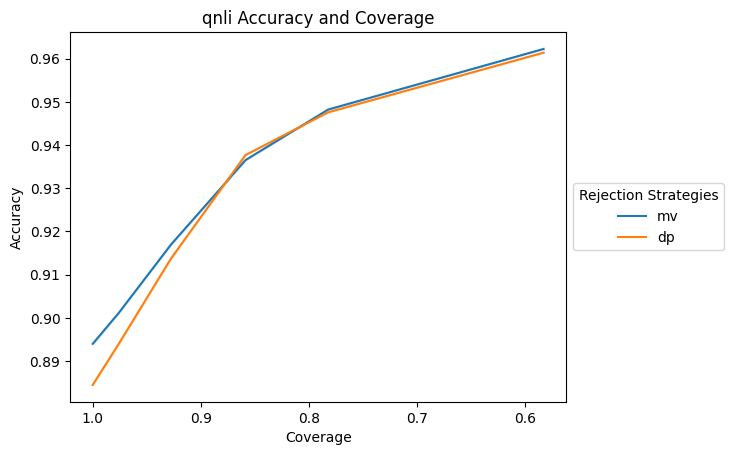

dict_keys(['match_vector', 'match_vector_time', 'prompt', 'match_vector_labels', 'agreement_mv', 'agreement_dp'])


In [42]:
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(agreement_mv["accuracy_coverage"]), label="mv")
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(agreement_dp["accuracy_coverage"]), label="dp")
plt.legend(title="Rejection Strategies", loc='center left', bbox_to_anchor=(1, 0.5))

# Set labels
plt.xlabel('Coverage')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()
plt.title(f'{Dataset_name} Accuracy and Coverage')
plt.show()

print(return_dict.keys())

import pickle
dataset_name = "Base_Phi_GLUE_QNLI"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

## QQP

In [44]:
Dataset_name = "qqp"
task = Dataset_name

datasets = {}
datasets[task] = load_dataset("glue", task)

def sentiment_prompt(split):
    prompt_dataset = []
    for s1,s2 in split:
        messages = [
            #{"role": "system", "content": "You assess whether two questions are asking the same thing or not. ONLY Respond with 'Yes' or 'No'"},
            {"role": "user", "content":  f"You assess whether two questions are asking the same thing or not. ONLY Respond with 'Yes' or 'No'. Question 1: '{s1}'. Question 2: '{s2}'"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

input_data = list(zip(datasets[Dataset_name]["validation"]["question1"],datasets[Dataset_name]["validation"]["question2"]))
val_prompt = sentiment_prompt(input_data)

input_data = list(zip(datasets[Dataset_name]["train"]["question1"],datasets[Dataset_name]["train"]["question2"]))
train_prompt = sentiment_prompt(input_data)

prompt = {"train":train_prompt[:10000],"val":val_prompt[:2000]}

Generating test split: 100%|██████████| 390965/390965 [00:00<00:00, 1081476.15 examples/s]


In [45]:
disable_dropout(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)  


warmup =  phi_inference(prompt["val"][:8],pipe,batch_size) # pipebulding dauert -verzerrt erste time bei infernece

start_time = time.perf_counter()
val_predictions = phi_inference(prompt["val"],pipe,batch_size)
MatchVectorTime_val = time.perf_counter() -start_time


start_time = time.perf_counter()
train_predictions = phi_inference(prompt["train"],pipe,batch_size)
MatchVectorTime_train = time.perf_counter() -start_time

100%|██████████| 2500/2500 [21:18<00:00,  1.96it/s]


In [48]:
label_dict = {
    0:"No",
    1:"Yes"
}
def postprocessing(txt):
    if txt in ["Yes","No"]:
        return txt
    else:
        txt = txt.strip()
        
        if "No." in txt or txt[:2]=="No":
            return "No"
        if "Yes." in txt or txt[:3]=="Yes":
            return "Yes"
        return txt[:8]


written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
val_predictions_clean = np.array([postprocessing(y) for y in val_predictions])
mv_val = np.array(val_predictions_clean) == written_label[:2000]

written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
train_predictions_clean = np.array([postprocessing(y) for y in train_predictions])
mv_train = np.array(train_predictions_clean) == written_label[:10000]


match_vector = {"train": mv_train,
                "val":mv_val}

match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_val}

match_vector_labels= {"train": datasets[Dataset_name]["train"]["label"],
                     "val": datasets[Dataset_name]["validation"]["label"]}

return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}

print(np.sum(mv_val)/len(mv_val),MatchVectorTime_val)
print(np.sum(mv_train)/len(mv_train),MatchVectorTime_train)

0.823 260.1498979181051
0.8113 1278.151493890211


### QQP Dropout

In [49]:
enable_dropout(model,0.1)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

warmup = phi_dropout(prompt["val"][:4],pipe,batch_size=4)

start_time = time.perf_counter()
val_dropout_results = phi_dropout(prompt["val"],pipe,batch_size=4)
most_common_values, frequencies = most_common_and_frequency(clean_dropout(val_dropout_results), axis=1)
time_val_dropout = time.perf_counter() -start_time


100%|██████████| 500/500 [04:12<00:00,  1.98it/s]


In [50]:
written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
mv_val_dropout = most_common_values == written_label[:2000]
agreement_mv = cov_acc_df_creator(frequencies/10,mv_val)
agreement_dp = cov_acc_df_creator(frequencies/10,mv_val_dropout)
agreement_mv["accuracy_coverage"]["test_time"] = time_val_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_val_dropout
return_dict["agreement_mv"] = agreement_mv
return_dict["agreement_dp"] = agreement_dp
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout)/len(mv_val_dropout))

0.827


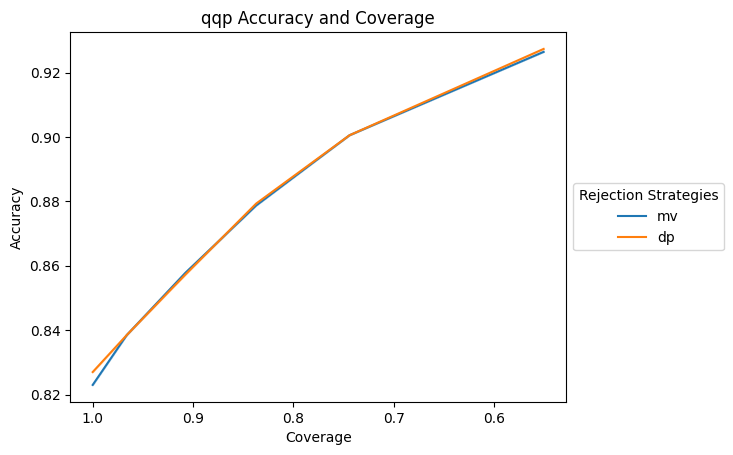

dict_keys(['match_vector', 'match_vector_time', 'prompt', 'match_vector_labels', 'agreement_mv', 'agreement_dp'])


In [51]:
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(agreement_mv["accuracy_coverage"]), label="mv")
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(agreement_dp["accuracy_coverage"]), label="dp")
plt.legend(title="Rejection Strategies", loc='center left', bbox_to_anchor=(1, 0.5))

# Set labels
plt.xlabel('Coverage')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()
plt.title(f'{Dataset_name} Accuracy and Coverage')
plt.show()

print(return_dict.keys())

import pickle
dataset_name = "Base_Phi_GLUE_QQP"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

## RTE

In [52]:
Dataset_name = "rte"
task = Dataset_name

datasets = {}
datasets[task] = load_dataset("glue", task)

def sentiment_prompt(split):
    prompt_dataset = []
    for s1,s2 in split:
        messages = [
            #{"role": "system", "content": "You evaluate if a hypothesis follows from a given premise. ONLY Respond with 'Yes' or 'No'"},
            {"role": "user", "content":  f"You evaluate if a hypothesis follows from a given premise. ONLY Respond with 'Yes' or 'No'. Premise: '{s1}'. Hypothesis: '{s2}' "}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

input_data = list(zip(datasets[Dataset_name]["validation"]["sentence1"],datasets[Dataset_name]["validation"]["sentence2"]))
val_prompt = sentiment_prompt(input_data)

input_data = list(zip(datasets[Dataset_name]["train"]["sentence1"],datasets[Dataset_name]["train"]["sentence2"]))
train_prompt = sentiment_prompt(input_data)

prompt = {"train":train_prompt[:10000],"val":val_prompt[:2000]}

Generating test split: 100%|██████████| 3000/3000 [00:00<00:00, 404192.35 examples/s]


In [53]:
disable_dropout(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)  


warmup =  phi_inference(prompt["val"][:8],pipe,batch_size) # pipebulding dauert -verzerrt erste time bei infernece

start_time = time.perf_counter()
val_predictions = phi_inference(prompt["val"],pipe,batch_size)
MatchVectorTime_val = time.perf_counter() -start_time


start_time = time.perf_counter()
train_predictions = phi_inference(prompt["train"],pipe,batch_size)
MatchVectorTime_train = time.perf_counter() -start_time

100%|██████████| 623/623 [04:38<00:00,  2.24it/s]


In [54]:
label_dict = {
    1:"No",
    0:"Yes"
}
def postprocessing(txt):
    if txt in ["Yes","No"]:
        return txt
    else:
        txt = txt.strip()
        
        if "No." in txt or txt[:2]=="No":
            return "No"
        if "Yes." in txt or txt[:3]=="Yes":
            return "Yes"
        return txt[:8]

written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
val_predictions_clean = np.array([postprocessing(y) for y in val_predictions])
mv_val = np.array(val_predictions_clean) == written_label[:2000]

written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
train_predictions_clean = np.array([postprocessing(y) for y in train_predictions])
mv_train = np.array(train_predictions_clean) == written_label[:10000]


match_vector = {"train": mv_train,
                "val":mv_val}

match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_val}

match_vector_labels= {"train": datasets[Dataset_name]["train"]["label"],
                     "val": datasets[Dataset_name]["validation"]["label"]}

return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}

print(np.sum(mv_val)/len(mv_val),MatchVectorTime_val)
print(np.sum(mv_train)/len(mv_train),MatchVectorTime_train)

0.8592057761732852 30.57976391352713
0.8891566265060241 278.44448006153107


### RTE DROPOUT

In [55]:
enable_dropout(model,0.1)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

warmup = phi_dropout(prompt["val"][:4],pipe,batch_size=4)

start_time = time.perf_counter()
val_dropout_results = phi_dropout(prompt["val"],pipe,batch_size=4)
most_common_values, frequencies = most_common_and_frequency(clean_dropout(val_dropout_results), axis=1)
time_val_dropout = time.perf_counter() -start_time

100%|██████████| 70/70 [00:38<00:00,  1.83it/s]


In [56]:
written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
mv_val_dropout = most_common_values == written_label[:2000]
agreement_mv = cov_acc_df_creator(frequencies/10,mv_val)
agreement_dp = cov_acc_df_creator(frequencies/10,mv_val_dropout)
agreement_mv["accuracy_coverage"]["test_time"] = time_val_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_val_dropout
return_dict["agreement_mv"] = agreement_mv
return_dict["agreement_dp"] = agreement_dp
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout)/len(mv_val_dropout))

0.8628158844765343


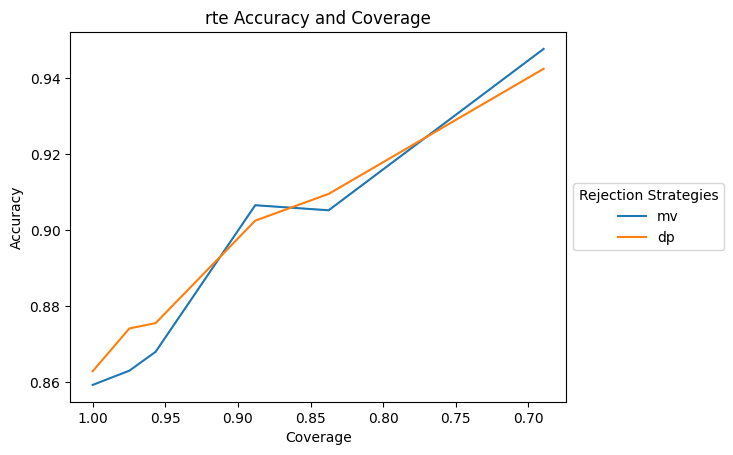

dict_keys(['match_vector', 'match_vector_time', 'prompt', 'match_vector_labels', 'agreement_mv', 'agreement_dp'])


In [57]:
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(agreement_mv["accuracy_coverage"]), label="mv")
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(agreement_dp["accuracy_coverage"]), label="dp")
plt.legend(title="Rejection Strategies", loc='center left', bbox_to_anchor=(1, 0.5))

# Set labels
plt.xlabel('Coverage')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()
plt.title(f'{Dataset_name} Accuracy and Coverage')
plt.show()

print(return_dict.keys())

import pickle
dataset_name = "Base_Phi_GLUE_RTE"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

## SST2

In [60]:
Dataset_name = "sst2"
task = Dataset_name

datasets = {}
datasets[task] = load_dataset("glue", task)

def sentiment_prompt(split):
    prompt_dataset = []
    for text in split:
        messages = [
            #{"role": "system", "content": "You classify the sentiment of a given sentence as either Positive or Negative. ONLY Respond with 'Positive' or 'Negative'"},
            {"role": "user", "content":  f"You classify the sentiment of a given sentence as either Positive or Negative. ONLY Respond with 'Positive' or 'Negative'. Text: '{text}'"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset


val_prompt = sentiment_prompt(datasets[Dataset_name]["validation"]["sentence"])
train_prompt = sentiment_prompt(datasets[Dataset_name]["train"]["sentence"])

prompt = {"train":train_prompt[:10000],"val":val_prompt[:2000]} #2000 extra für train falls ich die noch haben will, da val nur 872

In [61]:
disable_dropout(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)  


warmup =  phi_inference(prompt["val"][:8],pipe,batch_size) # pipebulding dauert -verzerrt erste time bei infernece

start_time = time.perf_counter()
val_predictions = phi_inference(prompt["val"],pipe,batch_size)
MatchVectorTime_val = time.perf_counter() -start_time


start_time = time.perf_counter()
train_predictions = phi_inference(prompt["train"],pipe,batch_size)
MatchVectorTime_train = time.perf_counter() -start_time

100%|██████████| 2500/2500 [24:49<00:00,  1.68it/s]


In [73]:
label_dict = {
    1: "Negative",
    0: "Positive"
}

def postprocessing(txt):
    if txt in ["Negative","Positive"]:
        return txt
    else:
        #txt = txt.strip()
        
        if txt[:8].lower()=="negative" or txt[:7].lower() == "ositive":
            return "Negative"
        if txt[:8].lower()=="positive" or txt[:7].lower() == "egative":
            return "Positive"
        return txt[:8]


written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
val_predictions_clean = np.array([postprocessing(y) for y in val_predictions])
mv_val = np.array(val_predictions_clean) == written_label[:2000]

written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
train_predictions_clean = np.array([postprocessing(y) for y in train_predictions])
mv_train = np.array(train_predictions_clean) == written_label[:10000]


match_vector = {"train": mv_train,
                "val":mv_val}

match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_val}

match_vector_labels= {"train": datasets[Dataset_name]["train"]["label"],
                     "val": datasets[Dataset_name]["validation"]["label"]}

return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}

print(np.sum(mv_val)/len(mv_val),MatchVectorTime_val)
print(np.sum(mv_train)/len(mv_train),MatchVectorTime_train)

0.9243119266055045 130.25454297848046
0.8377 1489.4452303135768


### SST2 DROPOUT

In [63]:
enable_dropout(model,0.1)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

warmup = phi_dropout(prompt["val"][:4],pipe,batch_size=4)

start_time = time.perf_counter()
val_dropout_results = phi_dropout(prompt["val"],pipe,batch_size=4)
most_common_values, frequencies = most_common_and_frequency(clean_dropout(val_dropout_results), axis=1)
time_val_dropout = time.perf_counter() -start_time

100%|██████████| 218/218 [02:26<00:00,  1.49it/s]


In [76]:
written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
mv_val_dropout = most_common_values == written_label[:2000]
agreement_mv = cov_acc_df_creator(frequencies/10,mv_val)
agreement_dp = cov_acc_df_creator(frequencies/10,mv_val_dropout)
agreement_mv["accuracy_coverage"]["test_time"] = time_val_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_val_dropout
return_dict["agreement_mv"] = agreement_mv
return_dict["agreement_dp"] = agreement_dp
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout)/len(mv_val_dropout))

0.9220183486238532


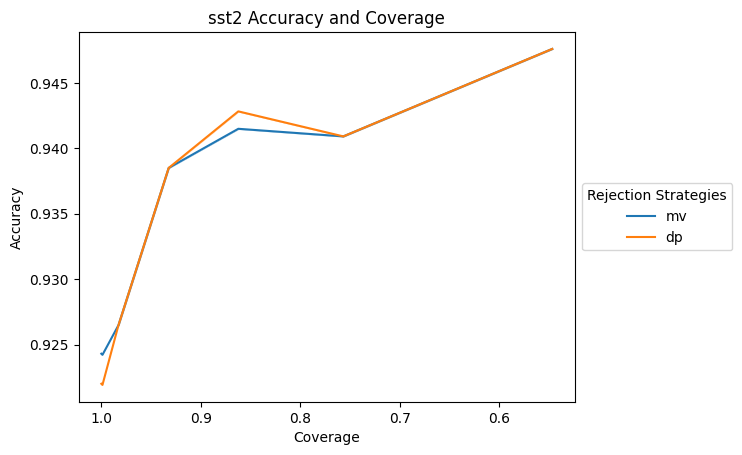

dict_keys(['match_vector', 'match_vector_time', 'prompt', 'match_vector_labels', 'agreement_mv', 'agreement_dp'])


In [77]:
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(agreement_mv["accuracy_coverage"]), label="mv")
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(agreement_dp["accuracy_coverage"]), label="dp")
plt.legend(title="Rejection Strategies", loc='center left', bbox_to_anchor=(1, 0.5))

# Set labels
plt.xlabel('Coverage')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()
plt.title(f'{Dataset_name} Accuracy and Coverage')
plt.show()

print(return_dict.keys())

import pickle
dataset_name = "Base_Phi_GLUE_SST2"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

## STSB

In [78]:
Dataset_name = "stsb"
task = Dataset_name

datasets = {}
datasets[task] = load_dataset("glue", task)

def sentiment_prompt(split):
    prompt_dataset = []
    for s1,s2 in split:
        messages = [
            #{"role": "system", "content": "You evaluate the similarity between two sentences on a scale from 1 to 5. ONLY Respond with '1','2','3','4' or '5'"},
            {"role": "user", "content":  f"You evaluate the similarity between two sentences on a scale from 1 to 5. ONLY Respond with '1','2','3','4' or '5'.Rate the similarity between these two sentences on a scale from 1 (completely different) to 5 (exactly the same): Sentence 1: '{s1}'. Sentence 2: '{s2}'."}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

input_data = list(zip(datasets[Dataset_name]["validation"]["sentence1"],datasets[Dataset_name]["validation"]["sentence2"]))
val_prompt = sentiment_prompt(input_data)

input_data = list(zip(datasets[Dataset_name]["train"]["sentence1"],datasets[Dataset_name]["train"]["sentence2"]))
train_prompt = sentiment_prompt(input_data)

prompt = {"train":train_prompt,"val":val_prompt}

Generating test split: 100%|██████████| 1379/1379 [00:00<00:00, 171234.09 examples/s]


In [79]:
disable_dropout(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)  


warmup =  phi_inference(prompt["val"][:8],pipe,batch_size) # pipebulding dauert -verzerrt erste time bei infernece

start_time = time.perf_counter()
val_predictions = phi_inference(prompt["val"],pipe,batch_size)
MatchVectorTime_val = time.perf_counter() -start_time


start_time = time.perf_counter()
train_predictions = phi_inference(prompt["train"],pipe,batch_size)
MatchVectorTime_train = time.perf_counter() -start_time

100%|██████████| 1438/1438 [14:05<00:00,  1.70it/s]


In [87]:
def postprocessing(txt):
    txt = txt.strip()
    if txt[:1] in ["1","2","3","4","5"]:
        return int(txt[:1])
    else:
        for number in ["1","2","3","4","5"]:
            if number in txt:
                return int(number)
        for number in ["1.0","2.0","3.0","4.0","5.0"]:
            if number in txt:
                return int(number)
        
    return -1

In [88]:
def postprocessing(txt):
    txt = txt.strip()
    if txt[:1] in ["1","2","3","4","5"]:
        return int(txt[:1])
    else:
        for number in ["1","2","3","4","5"]:
            if number in txt:
                return int(number)
        
        return -1


written_label = np.array(datasets[Dataset_name]["validation"]["label"])
written_label = np.round(written_label).astype(int)
val_predictions_clean = np.array([postprocessing(y) for y in val_predictions])
mv_val = np.array(val_predictions_clean) == written_label[:2000]
print(np.sum(mv_val)/len(mv_val))

written_label = np.array(datasets[Dataset_name]["train"]["label"])
written_label = np.round(written_label).astype(int)
train_predictions_clean = np.array([postprocessing(y) for y in train_predictions])
mv_train = np.array(train_predictions_clean) == written_label[:10000]
print(np.sum(mv_train)/len(mv_train))



match_vector = {"train": mv_train,
                "val":mv_val}

match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_val}

match_vector_labels= {"train": datasets[Dataset_name]["train"]["label"],
                     "val": datasets[Dataset_name]["validation"]["label"]}

return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}

print(np.sum(mv_val)/len(mv_val),MatchVectorTime_val)
print(np.sum(mv_train)/len(mv_train),MatchVectorTime_train)

0.4086666666666667
0.4145068707601322
0.4086666666666667 221.11009803786874
0.4145068707601322 845.4328613458201


### STSB Dropout

In [81]:
enable_dropout(model,0.1)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

warmup = phi_dropout(prompt["val"][:4],pipe,batch_size=4)

start_time = time.perf_counter()
val_dropout_results = phi_dropout(prompt["val"],pipe,batch_size=4)
most_common_values, frequencies = most_common_and_frequency(clean_dropout(val_dropout_results), axis=1)
time_val_dropout = time.perf_counter() -start_time

100%|██████████| 375/375 [04:17<00:00,  1.46it/s]


I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity between these two
I would rate the similarity betwee

In [97]:

written_label = np.array(datasets[Dataset_name]["validation"]["label"])
written_label = np.round(written_label).astype(int)

mv_val_dropout = most_common_values == written_label[:2000]



agreement_mv = cov_acc_df_creator(frequencies/10,mv_val)
agreement_dp = cov_acc_df_creator(frequencies/10,mv_val_dropout)
agreement_mv["accuracy_coverage"]["test_time"] = time_val_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_val_dropout
return_dict["agreement_mv"] = agreement_mv
return_dict["agreement_dp"] = agreement_dp
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout)/len(mv_val_dropout))

0.40066666666666667


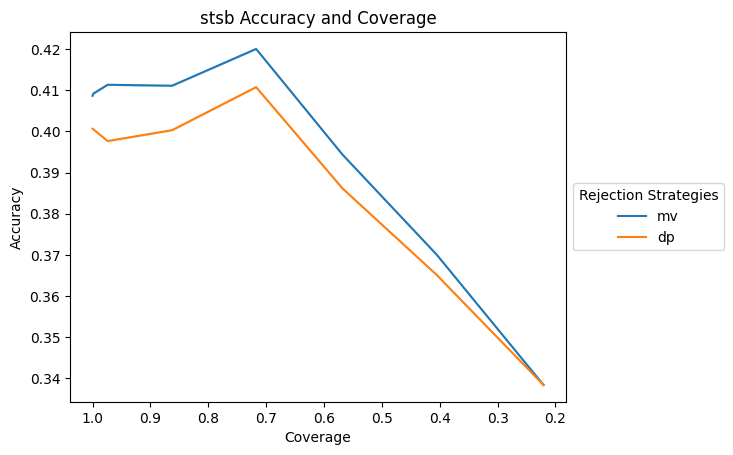

dict_keys(['match_vector', 'match_vector_time', 'prompt', 'match_vector_labels', 'agreement_mv', 'agreement_dp'])


In [98]:
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(agreement_mv["accuracy_coverage"]), label="mv")
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(agreement_dp["accuracy_coverage"]), label="dp")
plt.legend(title="Rejection Strategies", loc='center left', bbox_to_anchor=(1, 0.5))

# Set labels
plt.xlabel('Coverage')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()
plt.title(f'{Dataset_name} Accuracy and Coverage')
plt.show()

print(return_dict.keys())

import pickle
dataset_name = "Base_Phi_GLUE_STSB"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

## MRCP

In [4]:
#GLUE MRPC test
Dataset_name = "mrpc"
task = Dataset_name

datasets = {}
datasets[task] = load_dataset("glue", task)


def sentiment_prompt(split):
    prompt_dataset = []
    for s1,s2 in split:
        messages = [
            #{"role": "system", "content": "You are an AI assistant designed to evaluate if two sentences are paraphrases of each other. ONLY Respond with 'Yes' if they are paraphrases and 'No' if they are not."},
            {"role": "user", "content": f"You are an AI assistant designed to evaluate if two sentences are paraphrases of each other. ONLY Respond with 'Yes' if they are paraphrases and 'No' if they are not.Are the following sentences paraphrases?\n\nSentence 1: {s1}\nSentence 2: {s2}"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

#input_data = list(zip(datasets["mrpc"]["test"]["sentence1"],datasets["mrpc"]["test"]["sentence2"]))
#test_prompt = sentiment_prompt(input_data)

input_data = list(zip(datasets["mrpc"]["validation"]["sentence1"],datasets["mrpc"]["validation"]["sentence2"]))
val_prompt = sentiment_prompt(input_data)

input_data = list(zip(datasets["mrpc"]["train"]["sentence1"],datasets["mrpc"]["train"]["sentence2"]))
train_prompt = sentiment_prompt(input_data)

prompt = {"train":train_prompt,"val":val_prompt}

In [5]:
disable_dropout(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)  


warmup =  phi_inference(prompt["val"][:8],pipe,batch_size) # pipebulding dauert -verzerrt erste time bei infernece

start_time = time.perf_counter()
val_predictions = phi_inference(prompt["val"],pipe,batch_size)
MatchVectorTime_val = time.perf_counter() -start_time


start_time = time.perf_counter()
train_predictions = phi_inference(prompt["train"],pipe,batch_size)
MatchVectorTime_train = time.perf_counter() -start_time

  0%|          | 0/2 [00:00<?, ?it/s]The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48
You are not running the flash-attention implementation, expect numerical differences.
100%|██████████| 917/917 [06:21<00:00,  2.41it/s]


In [6]:
label_dict = {
    0:"No",
    1:"Yes"
}
def postprocessing(txt):
    if txt in ["Yes","No"]:
        return txt
    else:
        txt = txt.strip()
        
        if "No." in txt or txt[:2]=="No":
            return "No"
        if "Yes." in txt or txt[:3]=="Yes":
            return "Yes"
        return txt[:8]


written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
val_predictions_clean = np.array([postprocessing(y) for y in val_predictions])
mv_val = np.array(val_predictions_clean) == written_label[:2000]

written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
train_predictions_clean = np.array([postprocessing(y) for y in train_predictions])
mv_train = np.array(train_predictions_clean) == written_label[:10000]


match_vector = {"train": mv_train,
                "val":mv_val}

match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_val}

match_vector_labels= {"train": datasets[Dataset_name]["train"]["label"],
                     "val": datasets[Dataset_name]["validation"]["label"]}

return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}

print(np.sum(mv_val)/len(mv_val),MatchVectorTime_val)
print(np.sum(mv_train)/len(mv_train),MatchVectorTime_train)

0.7867647058823529 42.60831192275509
0.7889858233369684 381.22361258836463


### MRCP DROPOUT

In [7]:
enable_dropout(model,0.1)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

warmup = phi_dropout(prompt["val"][:4],pipe,batch_size=4)

start_time = time.perf_counter()
val_dropout_results = phi_dropout(prompt["val"],pipe,batch_size=4)
most_common_values, frequencies = most_common_and_frequency(clean_dropout(val_dropout_results), axis=1)
time_val_dropout = time.perf_counter() -start_time

100%|██████████| 102/102 [00:59<00:00,  1.72it/s]


In [8]:
written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
mv_val_dropout = most_common_values == written_label[:2000]
agreement_mv = cov_acc_df_creator(frequencies/10,mv_val)
agreement_dp = cov_acc_df_creator(frequencies/10,mv_val_dropout)
agreement_mv["accuracy_coverage"]["test_time"] = time_val_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_val_dropout
return_dict["agreement_mv"] = agreement_mv
return_dict["agreement_dp"] = agreement_dp
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout)/len(mv_val_dropout))

0.7745098039215687


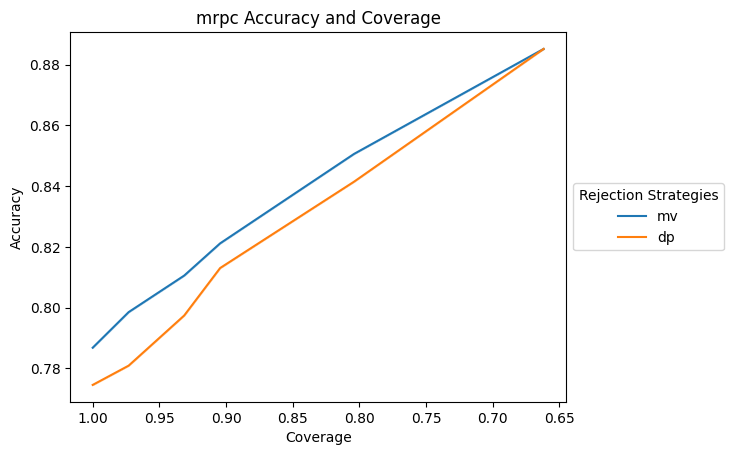

dict_keys(['match_vector', 'match_vector_time', 'prompt', 'match_vector_labels', 'agreement_mv', 'agreement_dp'])


In [9]:
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(agreement_mv["accuracy_coverage"]), label="mv")
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(agreement_dp["accuracy_coverage"]), label="dp")
plt.legend(title="Rejection Strategies", loc='center left', bbox_to_anchor=(1, 0.5))

# Set labels
plt.xlabel('Coverage')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()
plt.title(f'{Dataset_name} Accuracy and Coverage')
plt.show()

print(return_dict.keys())

import pickle
dataset_name = "Base_Phi_GLUE_MRPC"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

## MNLI

In [22]:
Dataset_name = "mnli"
task = Dataset_name

datasets = {}
datasets[task] = load_dataset("glue", task)


def sentiment_prompt(split):
    prompt_dataset = []
    for s1,s2 in split:
        messages = [
            #{"role": "system", "content": "You are a helpful assistant skilled at identifying logical relationships between two sentences. ONLY Respond with 'entailment', 'contradiction', or 'neutral'."},
            {"role": "user", "content": "You are a helpful assistant skilled at identifying logical relationships between two sentences. ONLY Respond with 'entailment', 'contradiction', or 'neutral'.Does the hypothesis entail the premise, contradict it, or is it neutral? "
                                        "Respond with 'entailment', 'contradiction', or 'neutral'."
                                         f"Premise: '{s1}'. Hypothesis: '{s2}'. "}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

input_data = list(zip(datasets[Dataset_name]["validation_mismatched"]["premise"],datasets[Dataset_name]["validation_mismatched"]["hypothesis"]))
val_prompt_mismatched = sentiment_prompt(input_data)

input_data = list(zip(datasets[Dataset_name]["validation_matched"]["premise"],datasets[Dataset_name]["validation_matched"]["hypothesis"]))
val_prompt_matched = sentiment_prompt(input_data)

input_data = list(zip(datasets[Dataset_name]["train"]["premise"],datasets[Dataset_name]["train"]["hypothesis"]))
train_prompt = sentiment_prompt(input_data)

prompt = {"train":train_prompt[:10000],"matched":val_prompt_matched[:2000], "unmatched":val_prompt_mismatched[:2000]}

In [16]:
disable_dropout(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)  


warmup =  phi_inference(prompt["train"][:8],pipe,batch_size) # pipebulding dauert -verzerrt erste time bei infernece

start_time = time.perf_counter()
matched_predictions = phi_inference(prompt["matched"],pipe,batch_size)
MatchVectorTime_matched = time.perf_counter() -start_time

start_time = time.perf_counter()
unmatched_predictions = phi_inference(prompt["mismatched"],pipe,batch_size)
MatchVectorTime_unmatched = time.perf_counter() -start_time

start_time = time.perf_counter()
train_predictions = phi_inference(prompt["train"],pipe,batch_size)
MatchVectorTime_train = time.perf_counter() -start_time

100%|██████████| 2500/2500 [24:26<00:00,  1.71it/s]  


In [19]:
label_dict = {
    0:"Entailment",
    1:"Neutral",
    2:"Contradiction"
}


def postprocessing(txt):
    if "neutral" in txt.lower():
        return "Neutral"
    elif "entailment" in txt.lower():
        return "Entailment"
    elif "contradiction" in txt.lower():
        return "Contradiction"
    else:
        return txt


written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation_matched"]["label"]])
matched_predictions_clean = np.array([postprocessing(y) for y in matched_predictions])
mv_matched = np.array(matched_predictions_clean) == written_label[:2000]

written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation_mismatched"]["label"]])
mismatched_predictions_clean = np.array([postprocessing(y) for y in unmatched_predictions])
mv_mismatched = np.array(mismatched_predictions_clean) == written_label[:2000]


written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
train_predictions_clean = np.array([postprocessing(y) for y in train_predictions])
mv_train = np.array(train_predictions_clean) == written_label[:10000]



match_vector = {"train": mv_train,
                "matched": mv_matched,
                "mismatched":mv_mismatched}

match_vector_time = {"train": MatchVectorTime_train,
                     "matched": MatchVectorTime_matched,
                     "mismatched": MatchVectorTime_unmatched}

match_vector_labels= {"train": datasets[Dataset_name]["train"]["label"][:10000],
                     "matched": datasets[Dataset_name]["validation_matched"]["label"][:2000],
                     "mismatched": datasets[Dataset_name]["validation_mismatched"]["label"][:2000]}


return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}


print(np.sum(mv_train)/len(mv_train))
print(np.sum(mv_matched)/len(mv_matched))
print(np.sum(mv_mismatched)/len(mv_mismatched))


0.8101
0.8305
0.8345


### MRPC DROPOUT

In [ ]:
enable_dropout(model,0.1)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

warmup = phi_dropout(prompt["train"][:4],pipe,batch_size=4)

start_time = time.perf_counter()
matched_dropout_results = phi_dropout(prompt["matched"],pipe,batch_size=4)
most_common_values_m, frequencies_m = most_common_and_frequency(clean_dropout(matched_dropout_results), axis=1)
time_matched_dropout = time.perf_counter() -start_time

start_time = time.perf_counter()
unmatched_dropout_results = phi_dropout(prompt["unmatched"],pipe,batch_size=4)
most_common_values_u, frequencies_u = most_common_and_frequency(clean_dropout(unmatched_dropout_results), axis=1)
time_unmatched_dropout = time.perf_counter() -start_time

In [23]:
"""
start_time = time.perf_counter()
unmatched_dropout_results = phi_dropout(prompt["unmatched"],pipe,batch_size=4)
most_common_values_u, frequencies_u = most_common_and_frequency(clean_dropout(unmatched_dropout_results), axis=1)
time_unmatched_dropout = time.perf_counter() -start_time
"""

100%|██████████| 500/500 [07:05<00:00,  1.18it/s]


In [25]:
written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation_matched"]["label"]])
matched_predictions_clean = np.array([postprocessing(y) for y in matched_predictions])
mv_matched = np.array(matched_predictions_clean) == written_label[:2000]

written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation_mismatched"]["label"]])
unmatched_predictions_clean = np.array([postprocessing(y) for y in unmatched_predictions])
mv_unmatched = np.array(unmatched_predictions_clean) == written_label[:2000]



In [28]:
written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation_matched"]["label"]])
mv_val_dropout_m = most_common_values_m == written_label[:2000]
agreement_mv = cov_acc_df_creator(frequencies_m/10,mv_matched)
agreement_dp = cov_acc_df_creator(frequencies_m/10,mv_val_dropout_m)
agreement_mv["accuracy_coverage"]["test_time"] = time_matched_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_matched_dropout
return_dict["agreement_mv_matched"] = agreement_mv
return_dict["agreement_dp_matched"] = agreement_dp
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout_m)/len(mv_val_dropout_m))



0.8065


In [29]:
written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation_mismatched"]["label"]])
mv_val_dropout_u = most_common_values_u == written_label[:2000]
agreement_mv = cov_acc_df_creator(frequencies_m/10,mv_unmatched)
agreement_dp = cov_acc_df_creator(frequencies_m/10,mv_val_dropout_u)
agreement_mv["accuracy_coverage"]["test_time"] = time_matched_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_matched_dropout
return_dict["agreement_mv_unmatched"] = agreement_mv
return_dict["agreement_dp_unmatched"] = agreement_dp
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout_u)/len(mv_val_dropout_u))

0.821


In [30]:

import pickle
dataset_name = "Base_Phi_GLUE_MNLI"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

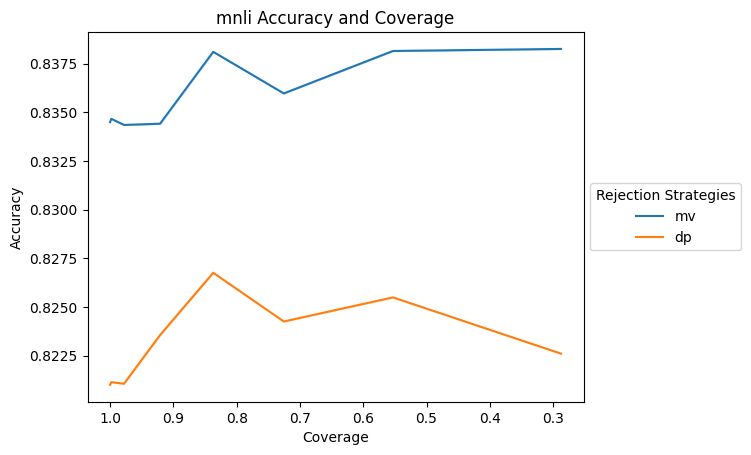

In [33]:
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(return_dict["agreement_mv_unmatched"]["accuracy_coverage"]), label="mv")
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(return_dict["agreement_dp_unmatched"]["accuracy_coverage"]), label="dp")
plt.legend(title="Rejection Strategies", loc='center left', bbox_to_anchor=(1, 0.5))

# Set labels
plt.xlabel('Coverage')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()
plt.title(f'{Dataset_name} Accuracy and Coverage')
plt.show()


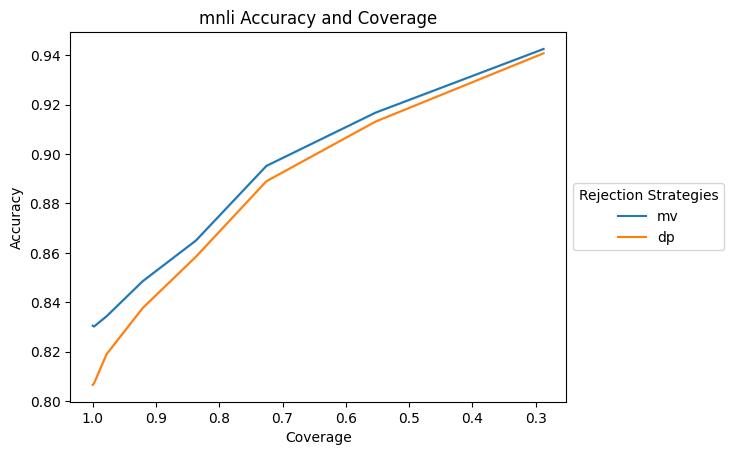

In [34]:
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(return_dict["agreement_mv_matched"]["accuracy_coverage"]), label="mv")
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(return_dict["agreement_dp_matched"]["accuracy_coverage"]), label="dp")
plt.legend(title="Rejection Strategies", loc='center left', bbox_to_anchor=(1, 0.5))

# Set labels
plt.xlabel('Coverage')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()
plt.title(f'{Dataset_name} Accuracy and Coverage')
plt.show()


# Non Glue Datasets

## Spellcheck

In [3]:
df = pd.read_csv('./dependencies/typo_pairs.csv')# Selbst gemachter Datensatz

inputs = list(df['Text'])  # Misspelled words from your dataset
targets = list(df['Label'])  # Corrected words (ground truth)

X_Dataset = {"train": inputs[:10000],"test": inputs[10000:12000]}
match_vector_labels = {"train": targets[:10000],"test": targets[10000:12000]}

Dataset_name = "Transformation"

In [4]:
def sentiment_prompt(split):
    prompt_dataset = []
    for text in split:
        messages = [
            #{"role": "system", "content": "You are a spell-checking assistant. Your task is to correct only typographical errors in the given text (e.g., keyboard mistakes or misspellings), without altering the meaning or structure of the sentence. If the text is already correct with no typographical errors, just return the correct text as is."},
            {"role": "user", "content": f"You are a spell-checking assistant. Your task is to correct only typographical errors in the given text (e.g., keyboard mistakes or misspellings), without altering the meaning or structure of the sentence. If the text is already correct with no typographical errors, just return the correct text as is. Text: {text}"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset


test_prompt = sentiment_prompt(X_Dataset["test"])
train_prompt = sentiment_prompt(X_Dataset["train"])
prompt = {"train":train_prompt[:10000],"test":test_prompt[:2000]}

In [5]:
#Test Promp ob alles klappt
prompt = {"train":train_prompt[:100],"test":test_prompt[:10]}

In [8]:
generation_args = {
    "max_new_tokens": 14,
    "return_full_text": False,
    #"temperature": 0.3,
    "do_sample": False,
}


disable_dropout(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)  


warmup =  phi_inference(prompt["test"][:8],pipe,batch_size) # pipebulding dauert -verzerrt erste time bei infernece

start_time = time.perf_counter()
test_predictions = phi_inference(prompt["test"],pipe,batch_size)
MatchVectorTime_test = time.perf_counter() -start_time


start_time = time.perf_counter()
train_predictions = phi_inference(prompt["train"],pipe,batch_size)
MatchVectorTime_train = time.perf_counter() -start_time

100%|██████████| 25/25 [00:48<00:00,  1.94s/it]


In [16]:
def postprocessing(text):
    text =  text.strip()
    if text.endswith('.'):
        return text[:-1]
    return text

test_pred = [postprocessing(txt) for txt in train_predictions]
test_label = [postprocessing(txt) for txt in match_vector_labels["train"]]
mv_train = np.array(test_pred) == np.array(test_label)[:len(test_pred)]
print(np.sum(mv_train)/len(mv_train))

test_pred = [postprocessing(txt) for txt in test_predictions]
test_label = [postprocessing(txt) for txt in match_vector_labels["test"]]
mv_test = np.array(test_pred) == np.array(test_label)[:len(test_pred)]
print(np.sum(mv_test)/len(mv_test))



match_vector = {"train": mv_train,
                "val":mv_test}

match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_test}

return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt, "match_vector_labels":match_vector_labels}

print(np.sum(mv_test)/len(mv_test),MatchVectorTime_test)
print(np.sum(mv_train)/len(mv_train),MatchVectorTime_train)

0.76
0.6
0.6 4.76538972556591
0.76 48.53492170665413


### Spellcheck Dropout

In [17]:
enable_dropout(model,0.1)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

warmup = phi_dropout(prompt["test"][:4],pipe,batch_size=4)

start_time = time.perf_counter()
val_dropout_results = phi_dropout(prompt["test"],pipe,batch_size=4)
most_common_values, frequencies = most_common_and_frequency(clean_dropout(val_dropout_results), axis=1)
time_val_dropout = time.perf_counter() -start_time

100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


In [21]:
test_label = [postprocessing(txt) for txt in match_vector_labels["test"]]
written_label = np.array(test_label)

mv_val_dropout = most_common_values == written_label[:len(most_common_values)]

agreement_mv = cov_acc_df_creator(frequencies/10,mv_test)
agreement_dp = cov_acc_df_creator(frequencies/10,mv_val_dropout)
agreement_mv["accuracy_coverage"]["test_time"] = time_val_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_val_dropout
return_dict["agreement_mv"] = agreement_mv
return_dict["agreement_dp"] = agreement_dp
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout)/len(mv_val_dropout))

0.6


In [ ]:
import pickle
dataset_name = "Base_Phi_TransformationSpellcheck"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

## Spam Dataset

In [24]:
from datasets import load_dataset
ds = load_dataset("SetFit/enron_spam") #'text','subject' 'label'   --->subject nutzen 70% acc, 96 bei text
#ds = load_dataset("SalehAhmad/Spam-Ham") #['label', 'sms_text'] #like 99.6% accuracy nicht nutzen
filtered_dataset_train = ds['train'].select(range(10000))
X_Dataset_train = filtered_dataset_train["subject"]
match_vector_labels_train = filtered_dataset_train['label']
filtered_dataset_test = ds['test'].select(range(2000))
X_Dataset_test = filtered_dataset_test["subject"]
match_vector_labels_test = filtered_dataset_test['label']

X_Dataset = {"train": X_Dataset_train,"test": X_Dataset_test}
match_vector_labels = {"train": match_vector_labels_train,"test" : match_vector_labels_test}
Dataset_name = "Spam"




label_dict = {
    0: 'Ham',
    1: 'Spam',
}
label_text_train = [label_dict[val] for val in match_vector_labels["train"]]
label_text_test = [label_dict[val] for val in match_vector_labels["test"]]


def sentiment_prompt(split):
    prompt_dataset = []
    for text in split:
        messages = [
            #{"role": "system", "content": "You are a highly accurate email classifier. Your task is to classify the given email header into one of the following categories:\n- Spam\n- Ham\n\nYou should strictly answer with only one of these categories, without any explanations or additional text."},
            {"role": "user", "content": f"You are a highly accurate email classifier. Your task is to classify the given email header into one of the following categories:\n- Spam\n- Ham\n\nYou should strictly answer with only one of these categories, without any explanations or additional text. Classify the following email header into one of the categories: 'Spam' or 'Ham'.\n\nEmail Header: {text}"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

train_prompt = sentiment_prompt(X_Dataset["train"])
test_prompt = sentiment_prompt(X_Dataset["test"])
prompt = {"train":train_prompt[:10000],"test":test_prompt[:2000]}

Repo card metadata block was not found. Setting CardData to empty.
Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 47990.57 examples/s]


In [25]:
generation_args = {
    "max_new_tokens": 4,
    "return_full_text": False,
    #"temperature": 0.3,
    "do_sample": False,
}


disable_dropout(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)  


warmup =  phi_inference(prompt["test"][:8],pipe,batch_size) # pipebulding dauert -verzerrt erste time bei infernece

start_time = time.perf_counter()
test_predictions = phi_inference(prompt["test"],pipe,batch_size)
MatchVectorTime_test = time.perf_counter() -start_time


start_time = time.perf_counter()
train_predictions = phi_inference(prompt["train"],pipe,batch_size)
MatchVectorTime_train = time.perf_counter() -start_time

100%|██████████| 2500/2500 [21:59<00:00,  1.89it/s]


In [33]:
def postprocessing(text):
    return text.strip()

test_pred = [postprocessing(txt) for txt in train_predictions]
test_label = [label_dict[txt] for txt in match_vector_labels["train"]]
mv_train = np.array(test_pred) == np.array(test_label)[:len(test_pred)]
print(np.sum(mv_train)/len(mv_train))

test_pred = [postprocessing(txt) for txt in test_predictions]
test_label = [label_dict[txt] for txt in match_vector_labels["test"]]
mv_test = np.array(test_pred) == np.array(test_label)[:len(test_pred)]
print(np.sum(mv_test)/len(mv_test))



match_vector = {"train": mv_train,
                "val":mv_test}

match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_test}

return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt, "match_vector_labels":match_vector_labels}

print(np.sum(mv_test)/len(mv_test),MatchVectorTime_test)
print(np.sum(mv_train)/len(mv_train),MatchVectorTime_train)

0.739
0.7555
0.7555 261.2470943974331
0.739 1319.9494855599478


### Spam Dataset Dropout

In [ ]:
enable_dropout(model,0.1)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

warmup = phi_dropout(prompt["test"][:4],pipe,batch_size=4)

start_time = time.perf_counter()
val_dropout_results = phi_dropout(prompt["test"],pipe,batch_size=4)
most_common_values, frequencies = most_common_and_frequency(clean_dropout(val_dropout_results), axis=1)
time_val_dropout = time.perf_counter() -start_time


test_label = [label_dict[txt] for txt in match_vector_labels["test"]]
written_label = np.array(test_label)

mv_val_dropout = most_common_values == written_label[:len(most_common_values)]

agreement_mv = cov_acc_df_creator(frequencies/10,mv_test)
agreement_dp = cov_acc_df_creator(frequencies/10,mv_val_dropout)
agreement_mv["accuracy_coverage"]["test_time"] = time_val_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_val_dropout
return_dict["agreement_mv"] = agreement_mv
return_dict["agreement_dp"] = agreement_dp
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout)/len(mv_val_dropout))

In [37]:
import pickle
dataset_name = "Base_Phi_Spam"# "Base_Phi_Spam_text"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

## Spam Text

In [ ]:
from datasets import load_dataset
ds = load_dataset("SetFit/enron_spam") #'text','subject' 'label'   --->subject nutzen 70% acc, 96 bei text
#ds = load_dataset("SalehAhmad/Spam-Ham") #['label', 'sms_text'] #like 99.6% accuracy nicht nutzen
filtered_dataset_train = ds['train'].select(range(10000))
X_Dataset_train = filtered_dataset_train["text"]
match_vector_labels_train = filtered_dataset_train['label']
filtered_dataset_test = ds['test'].select(range(2000))
X_Dataset_test = filtered_dataset_test["text"]
match_vector_labels_test = filtered_dataset_test['label']

X_Dataset = {"train": X_Dataset_train,"test": X_Dataset_test}
match_vector_labels = {"train": match_vector_labels_train,"test" : match_vector_labels_test}

Dataset_name = "Spam_text"





label_dict = {
    0: 'Ham',
    1: 'Spam',
}
label_text_train = [label_dict[val] for val in match_vector_labels["train"]]
label_text_test = [label_dict[val] for val in match_vector_labels["test"]]


def sentiment_prompt(split):
    prompt_dataset = []
    for text in split:
        if len(text) > 1024: #manche Email sind quasi unendlich lang, daher  einfach text verkleinern ~ entspricht so 128-256 Tokens
            text = text[:1024]
        messages = [
            #{"role": "system", "content": "You are a highly accurate email classifier. Your task is to classify the given email into one of the following categories:\n- Spam\n- Ham\n\nYou should strictly answer with only one of these categories, without any explanations or additional text."},
            {"role": "user", "content": f"You are a highly accurate email classifier. Your task is to classify the given email into one of the following categories:\n- Spam\n- Ham\n\nYou should strictly answer with only one of these categories, without any explanations or additional text. Classify the following email into one of the categories: 'Spam' or 'Ham'.\n\nEmail: {text}"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

train_prompt = sentiment_prompt(X_Dataset["train"])
test_prompt = sentiment_prompt(X_Dataset["test"])
prompt = {"train":train_prompt[:10000],"test":test_prompt[:2000]}




generation_args = {
    "max_new_tokens": 4,
    "return_full_text": False,
    #"temperature": 0.3,
    "do_sample": False,
}
disable_dropout(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)  
warmup =  phi_inference(prompt["test"][:8],pipe,batch_size) # pipebulding dauert -verzerrt erste time bei infernece

start_time = time.perf_counter()
test_predictions = phi_inference(prompt["test"],pipe,batch_size)
MatchVectorTime_test = time.perf_counter() -start_time


start_time = time.perf_counter()
train_predictions = phi_inference(prompt["train"],pipe,batch_size)
MatchVectorTime_train = time.perf_counter() -start_time



def postprocessing(text):
    return text.strip()

test_pred = [postprocessing(txt) for txt in train_predictions]
test_label = [label_dict[txt] for txt in match_vector_labels["train"]]
mv_train = np.array(test_pred) == np.array(test_label)[:len(test_pred)]
print(np.sum(mv_train)/len(mv_train))

test_pred = [postprocessing(txt) for txt in test_predictions]
test_label = [label_dict[txt] for txt in match_vector_labels["test"]]
mv_test = np.array(test_pred) == np.array(test_label)[:len(test_pred)]
print(np.sum(mv_test)/len(mv_test))



match_vector = {"train": mv_train,
                "val":mv_test}

match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_test}

return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt, "match_vector_labels":match_vector_labels}

print(np.sum(mv_test)/len(mv_test),MatchVectorTime_test)
print(np.sum(mv_train)/len(mv_train),MatchVectorTime_train)




### Spam Text Dropout

In [ ]:
enable_dropout(model,0.1)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

warmup = phi_dropout(prompt["test"][:4],pipe,batch_size=4)

start_time = time.perf_counter()
val_dropout_results = phi_dropout(prompt["test"],pipe,batch_size=4)
most_common_values, frequencies = most_common_and_frequency(clean_dropout(val_dropout_results), axis=1)
time_val_dropout = time.perf_counter() -start_time


test_label = [label_dict[txt] for txt in match_vector_labels["test"]]
written_label = np.array(test_label)

mv_val_dropout = most_common_values == written_label[:len(most_common_values)]

agreement_mv = cov_acc_df_creator(frequencies/10,mv_test)
agreement_dp = cov_acc_df_creator(frequencies/10,mv_val_dropout)
agreement_mv["accuracy_coverage"]["test_time"] = time_val_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_val_dropout
return_dict["agreement_mv"] = agreement_mv
return_dict["agreement_dp"] = agreement_dp
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout)/len(mv_val_dropout))



import pickle
dataset_name = "Base_Phi_Spam_text"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

## AG NEWS

In [3]:
from datasets import load_dataset

ds = load_dataset("fancyzhx/ag_news")
X_train = ds["train"]["text"][50000:60000]#auf ersten 50k Daten Roberta Modell Trainiert
Y_train = ds["train"]["label"][50000:60000]
X_test = ds["test"]["text"][2000:4000] #Irgendwelche 2000 Test Datensätze 
Y_test = ds["test"]["label"][2000:4000]

X_Dataset = {"train": X_train,"test": X_test}
match_vector_labels = {"train": Y_train,"test" : Y_test}

In [4]:
label_dict = {
    0: 'World',
    1: 'Sports',
    2: 'Business',
    3: 'Science/Technology'
}

label_text_train = [label_dict[val] for val in Y_train]
label_text_test = [label_dict[val] for val in Y_test]


def sentiment_prompt(split):
    prompt_dataset = []
    for text in split:
        if len(text) > 1024: #manche lang, daher  einfach text verkleinern ~ entspricht so 128-256 Tokens
            text = text[:1024]
        messages = [
            #{"role": "system", "content": "You are a highly accurate email classifier. Your task is to classify the given email into one of the following categories:\n- Spam\n- Ham\n\nYou should strictly answer with only one of these categories, without any explanations or additional text."},
            {"role": "user", "content": f"Your task is to classify the given news article into one of the following categories:\n- World\n- Sports\n- Business\n- Science/Technology\n\nYou should strictly answer with only one of these categories, without any explanations or additional text. Classify the following news article into one of the categories: 'World', 'Sports', 'Business', 'Science/Technology'.\n\nArticle: {text}"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

train_prompt = sentiment_prompt(X_Dataset["train"])
test_prompt = sentiment_prompt(X_Dataset["test"])
prompt = {"train":train_prompt[:10000],"test":test_prompt[:2000]}

generation_args = {
    "max_new_tokens": 6,
    "return_full_text": False,
    #"temperature": 0.3,
    "do_sample": False,
}
disable_dropout(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)  
warmup =  phi_inference(prompt["test"][:8],pipe,batch_size) # pipebulding dauert -verzerrt erste time bei infernece

start_time = time.perf_counter()
test_predictions = phi_inference(prompt["test"],pipe,batch_size)
MatchVectorTime_test = time.perf_counter() -start_time


  0%|          | 0/2 [00:00<?, ?it/s]The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48
You are not running the flash-attention implementation, expect numerical differences.
100%|██████████| 500/500 [04:08<00:00,  2.01it/s]


In [7]:
start_time = time.perf_counter()
train_predictions = phi_inference(prompt["train"],pipe,batch_size)
MatchVectorTime_train = time.perf_counter() -start_time

100%|██████████| 2500/2500 [20:40<00:00,  2.02it/s]


In [8]:


def postprocessing(text):
    text = text.strip()
    if text in ["World","Sports","Business","Science/Technology"]:
        return text
    else:
        text = text.lower()
        if "world" in text:
            return "World"
        elif "sports" in text:
            return "Sports"
        elif "business" in text:
            return "Business"
        elif "science" in text or "technology" in text:
            return "Science/Technology"
    return text

test_pred = [postprocessing(txt) for txt in train_predictions]
test_label = [label_dict[txt] for txt in match_vector_labels["train"]]
mv_train = np.array(test_pred) == np.array(test_label)[:len(test_pred)]
print(np.sum(mv_train)/len(mv_train))

test_pred = [postprocessing(txt) for txt in test_predictions]
test_label = [label_dict[txt] for txt in match_vector_labels["test"]]
mv_test = np.array(test_pred) == np.array(test_label)[:len(test_pred)]
print(np.sum(mv_test)/len(mv_test))



match_vector = {"train": mv_train,
                "val":mv_test}

match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_test}

return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt, "match_vector_labels":match_vector_labels}

print(np.sum(mv_test)/len(mv_test),MatchVectorTime_test)
print(np.sum(mv_train)/len(mv_train),MatchVectorTime_train)


politics
energy
documentaries
health
entertainment
health
health
entertainment
entertainment
environment
entertainment
environment
the given news article does not
energy
entertainment
entertainment
health
entertainment
health
health
arts/culture
entertainment
health
health
health
automotive
health
education
entertainment
literature
health
pharmaceuticals
entertainment
environment
home entertainment
environment
this article does not fit into
entertainment
entertainment
health
education
entertainment
entertainment
entertainment
opinion
education
politics
agriculture
environment
energy
health
entertainment
health
health
0.7766
art
arts/entertainment
entertainment
health
entertainment
health
health
health
health
entertainment
entertainment
energy
energy
entertainment
entertainment
health
0.7765
0.7765 248.6732370974496
0.7766 1240.3695295145735


### AG NEWS DROPOUT

In [9]:
enable_dropout(model,0.1)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

warmup = phi_dropout(prompt["test"][:4],pipe,batch_size=4)

start_time = time.perf_counter()
val_dropout_results = phi_dropout(prompt["test"],pipe,batch_size=4)
most_common_values, frequencies = most_common_and_frequency(clean_dropout(val_dropout_results), axis=1)
time_val_dropout = time.perf_counter() -start_time


test_label = [label_dict[txt] for txt in match_vector_labels["test"]]
written_label = np.array(test_label)

mv_val_dropout = most_common_values == written_label[:len(most_common_values)]

agreement_mv = cov_acc_df_creator(frequencies/10,mv_test)
agreement_dp = cov_acc_df_creator(frequencies/10,mv_val_dropout)
agreement_mv["accuracy_coverage"]["test_time"] = time_val_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_val_dropout
return_dict["agreement_mv"] = agreement_mv
return_dict["agreement_dp"] = agreement_dp
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout)/len(mv_val_dropout))



import pickle
dataset_name = "Base_Phi_AG_News"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

100%|██████████| 500/500 [04:40<00:00,  1.78it/s]


entertainment
society/culture
sci/tech
sci/tech
art-ltd
art
art

(note:
art
health
health
health
health
healthdaynews
b:
economics/finance
space
health
entertainment/culture
entertainment
entertainment
answer: entertainment
entertainment
entertainment/entertainment
entertainment

health
politics
environment
begründet
! befit-be
entertainment
tutor: the
entertainment
entertainment

health
health
healthdaynews -- americans are
healthdaynews -- americans are
health

finance
this article does not fit into
security
strikes at london air

environment
environment
- this article should
environment
ing the you' a b
military/defense
military
health
defense
the ministry of manpower said
space

- assistant
none of the provided categories (
ly
 erst auf ist
the latest round of polls
education
government accountability office (ga
welt
fake drugs are a
dating
air canada confirms order for
labor
work
labor
labor
labor/workers' rights
labor
begrared: the san francisco
adventure/exploration
environment


## Sentiment

In [10]:
from datasets import concatenate_datasets,load_dataset
ds = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset")    #'text', 'label', 'sentiment'

dataset= ds['train'].select(range(10001)) #==10000 nach Filter
mask = [i for i in range(len(dataset)) if i != 5639]
filtered_dataset = dataset.select(mask)

X_Dataset = {"train": filtered_dataset["text"],"test": ds["test"].select(range(2000))["text"]}
match_vector_labels = {"train": filtered_dataset["label"],"test" : ds["test"].select(range(2000))["label"]}
match_vector_sentiment = {"train": filtered_dataset["sentiment"],"test" : ds["test"].select(range(2000))["sentiment"]}
Dataset_name = "Sentiment"


In [11]:
def sentiment_prompt(split):
    prompt_dataset = []
    for text in split:
        messages = [
            {"role": "system", "content": "You are a sentiment analysis model. Respond to each question with one of the following choices: 'positive', 'neutral', or 'negative'. Do not provide any other answers."},           
            {"role": "human", "content": f"Now, analyze the sentiment of the following Text: '{text}'"}
        ]
        prompt_dataset.append(messages)
    return prompt_dataset

train_prompt = sentiment_prompt(X_Dataset["train"])
test_prompt = sentiment_prompt(X_Dataset["test"])
prompt = {"train":train_prompt,"test":test_prompt}

In [15]:
label_dict = {
    0:"negative",
    1:"neutral",
    2:"positive"
}

label_text_train = [label_dict[val] for val in match_vector_labels["train"]]
label_text_test = [label_dict[val] for val in match_vector_labels["test"]]


def sentiment_prompt(split):
    prompt_dataset = []
    for text in split:
        if len(text) > 1024: #manche lang, daher  einfach text verkleinern ~ entspricht so 128-256 Tokens
            text = text[:1024]
        messages = [
            #{"role": "system", "content": "You are a highly accurate email classifier. Your task is to classify the given email into one of the following categories:\n- Spam\n- Ham\n\nYou should strictly answer with only one of these categories, without any explanations or additional text."},
            {"role": "user", "content": f"You are a sentiment analysis model. Respond to each question with one of the following choices: 'positive', 'neutral', or 'negative'. Do not provide any other answers. Now, analyze the sentiment of the following Text: {text}"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

train_prompt = sentiment_prompt(X_Dataset["train"])
test_prompt = sentiment_prompt(X_Dataset["test"])
prompt = {"train":train_prompt[:10000],"test":test_prompt[:2000]}

generation_args = {
    "max_new_tokens": 4,
    "return_full_text": False,
    #"temperature": 0.3,
    "do_sample": False,
}
disable_dropout(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)  
warmup =  phi_inference(prompt["test"][:8],pipe,batch_size) # pipebulding dauert -verzerrt erste time bei infernece

start_time = time.perf_counter()
test_predictions = phi_inference(prompt["test"],pipe,batch_size)
MatchVectorTime_test = time.perf_counter() -start_time

100%|██████████| 500/500 [03:25<00:00,  2.43it/s]


In [17]:
start_time = time.perf_counter()
train_predictions = phi_inference(prompt["train"],pipe,batch_size)
MatchVectorTime_train = time.perf_counter() -start_time


100%|██████████| 2500/2500 [16:54<00:00,  2.47it/s]


In [18]:

def postprocessing(txt):
    txt = txt.strip()
    if txt in ["negative","positive","neutral"]:
        return txt
    else:      
        if txt[:8].lower()=="negative" or txt[:7].lower() == "ositive":
            return "negative"
        if txt[:8].lower()=="positive" or txt[:7].lower() == "egative":
            return "positive"
        if txt[:7].lower()=="neutral" or txt[:6].lower() == "eutral":
            return "neutral"
        return txt[:8]

test_pred = [postprocessing(txt) for txt in train_predictions]
test_label = [label_dict[txt] for txt in match_vector_labels["train"]]
mv_train = np.array(test_pred) == np.array(test_label)[:len(test_pred)]
print(np.sum(mv_train)/len(mv_train))

test_pred = [postprocessing(txt) for txt in test_predictions]
test_label = [label_dict[txt] for txt in match_vector_labels["test"]]
mv_test = np.array(test_pred) == np.array(test_label)[:len(test_pred)]
print(np.sum(mv_test)/len(mv_test))



match_vector = {"train": mv_train,
                "val":mv_test}

match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_test}

return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt, "match_vector_labels":match_vector_labels}

print(np.sum(mv_test)/len(mv_test),MatchVectorTime_test)
print(np.sum(mv_train)/len(mv_train),MatchVectorTime_train)

0.6755
0.6755
0.6755 205.35180213395506
0.6755 1014.399762715213


### Sentiment Dropout

In [35]:
enable_dropout(model,0.1)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

warmup = phi_dropout(prompt["test"][:4],pipe,batch_size=4)

start_time = time.perf_counter()
val_dropout_results = phi_dropout(prompt["test"],pipe,batch_size=4)
most_common_values, frequencies = most_common_and_frequency(clean_dropout(val_dropout_results), axis=1)
time_val_dropout = time.perf_counter() -start_time


test_label = [label_dict[txt] for txt in match_vector_labels["test"]]
written_label = np.array(test_label)

mv_val_dropout = most_common_values == written_label[:len(most_common_values)]

agreement_mv = cov_acc_df_creator(frequencies/10,mv_test)
agreement_dp = cov_acc_df_creator(frequencies/10,mv_val_dropout)
agreement_mv["accuracy_coverage"]["test_time"] = time_val_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_val_dropout
return_dict["agreement_mv"] = agreement_mv
return_dict["agreement_dp"] = agreement_dp
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout)/len(mv_val_dropout))



import pickle
dataset_name = "Base_Phi_Sentiment"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

100%|██████████| 500/500 [03:39<00:00,  2.28it/s]


0.6725


## QA

In [38]:
from datasets import load_dataset
#Shuffle, da 5x quasi gleiche Frage sonnst immer dran kommt
ds = load_dataset("rajpurkar/squad")

filtered_dataset = ds['train'].shuffle(seed=42).select(range(10000))
filtered_dataset = pd.DataFrame(filtered_dataset)
X_Dataset_train = (filtered_dataset['question'] + ' [SEP] ' + filtered_dataset['context']).tolist()
labels_train = [entry['text'][0] for entry in filtered_dataset['answers']]

filtered_dataset_test = ds['validation'].shuffle(seed=42).select(range(2000))
filtered_dataset_test = pd.DataFrame(filtered_dataset_test)
X_Dataset_test = (filtered_dataset_test['question'] + ' [SEP] ' + filtered_dataset_test['context']).tolist()
labels_test = [entry['text'][0] for entry in filtered_dataset_test['answers']]

X_Dataset = {"train": X_Dataset_train,"test": X_Dataset_test}
match_vector_labels = {"train": labels_train,"test" : labels_test}

Dataset_name = "Question Answering"

Generating validation split: 100%|██████████| 10570/10570 [00:00<00:00, 292962.97 examples/s]


In [ ]:
{"role": "user", "content": text}


{"role": "user", "content": ("You are an extractive question-answering assistant. Your task is to extract relevant information "
"exactly as it appears in the provided context. Do not reformat, rephrase, capitalize, transform, or interpret the information. "
"Your output must match the text verbatim from the context, including capitalization, punctuation, and formatting. "
"Answers should always be in 1-2 words or short phrases and directly taken from the context."
"Example 1: Question: When did Massachusetts first require children to be educated in schools? Context: Massachusetts introduced the first laws requiring education for children in 1723. Answer: 1723"
"Example 2: Question: How many people attended the event? Context: Ten million people attended the event. Answer: Ten million"
"Example 3: Question: What is the main nutrient found in rice? Context: Carbohydrates are the main nutrient found in rice. Answer: Carbohydrates"
"Example 4: Where did the Minion leaders meet? Context: The Minion leaders often met at the Minion Institute in Minionland. Answer: Minion Institute"
f"{text}"
)



In [40]:
def sentiment_prompt(split):
    prompt_dataset = []
    for text in split:
        text = "Extract the Answer for this Question from the given Context: " + text 
        text = text.replace("[SEP]", "[SEP] Context:")
        if len(text) > 1600: #manche Email sind unendlich lang, daher  einfach text verkleinern ~ entspricht so 128-256
            text = text[:1600]
                    
        messages = [
            {"role": "user", "content": ("You are an extractive question-answering assistant. Your task is to extract relevant information "
            "exactly as it appears in the provided context. Do not reformat, rephrase, capitalize, transform, or interpret the information. "
            "Your output must match the text verbatim from the context, including capitalization, punctuation, and formatting. "
            "Answers should always be in 1-2 words or short phrases and directly taken from the context."
            "Example 1: Question: When did Massachusetts first require children to be educated in schools? Context: Massachusetts introduced the first laws requiring education for children in 1723. Answer: 1723"
            "Example 2: Question: How many people attended the event? Context: Ten million people attended the event. Answer: Ten million"
            "Example 3: Question: What is the main nutrient found in rice? Context: Carbohydrates are the main nutrient found in rice. Answer: Carbohydrates"
            "Example 4: Where did the Minion leaders meet? Context: The Minion leaders often met at the Minion Institute in Minionland. Answer: Minion Institute"
            f"{text}"
            )}
        ]


        prompt_dataset.append(messages)
    return prompt_dataset

train_prompt = sentiment_prompt(X_Dataset["train"])
test_prompt = sentiment_prompt(X_Dataset["test"])
prompt = {"train":train_prompt[:10000],"test":test_prompt[:2000]}

In [41]:
#Test Promp ob alles klappt
prompt = {"train":train_prompt[:100],"test":test_prompt[:10]}

In [42]:
generation_args = {
    "max_new_tokens": 14,
    "return_full_text": False,
    #"temperature": 0.3,
    "do_sample": False,
}


disable_dropout(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)  


warmup =  phi_inference(prompt["test"][:8],pipe,batch_size) # pipebulding dauert -verzerrt erste time bei infernece

start_time = time.perf_counter()
test_predictions = phi_inference(prompt["test"],pipe,batch_size)
MatchVectorTime_test = time.perf_counter() -start_time


start_time = time.perf_counter()
train_predictions = phi_inference(prompt["train"],pipe,batch_size)
MatchVectorTime_train = time.perf_counter() -start_time

100%|██████████| 25/25 [00:36<00:00,  1.46s/it]


In [43]:
def postprocessing(text):
    text =  text.strip()
    if text.endswith('.'):
        return text[:-1]
    return text

test_pred = [postprocessing(txt) for txt in train_predictions]
test_label = [postprocessing(txt) for txt in match_vector_labels["train"]]
mv_train = np.array(test_pred) == np.array(test_label)[:len(test_pred)]
print(np.sum(mv_train)/len(mv_train))

test_pred = [postprocessing(txt) for txt in test_predictions]
test_label = [postprocessing(txt) for txt in match_vector_labels["test"]]
mv_test = np.array(test_pred) == np.array(test_label)[:len(test_pred)]
print(np.sum(mv_test)/len(mv_test))



match_vector = {"train": mv_train,
                "val":mv_test}

match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_test}

return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt, "match_vector_labels":match_vector_labels}

print(np.sum(mv_test)/len(mv_test),MatchVectorTime_test)
print(np.sum(mv_train)/len(mv_train),MatchVectorTime_train)

0.4
0.6
0.6 3.1997883217409253
0.4 36.40221410896629


### QA DROPOUT

In [44]:
enable_dropout(model,0.1)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

warmup = phi_dropout(prompt["test"][:4],pipe,batch_size=4)

start_time = time.perf_counter()
val_dropout_results = phi_dropout(prompt["test"],pipe,batch_size=4)
most_common_values, frequencies = most_common_and_frequency(clean_dropout(val_dropout_results), axis=1)
time_val_dropout = time.perf_counter() -start_time

100%|██████████| 3/3 [00:03<00:00,  1.33s/it]


In [45]:
test_label = [postprocessing(txt) for txt in match_vector_labels["test"]]
written_label = np.array(test_label)

mv_val_dropout = most_common_values == written_label[:len(most_common_values)]

agreement_mv = cov_acc_df_creator(frequencies/10,mv_test)
agreement_dp = cov_acc_df_creator(frequencies/10,mv_val_dropout)
agreement_mv["accuracy_coverage"]["test_time"] = time_val_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_val_dropout
return_dict["agreement_mv"] = agreement_mv
return_dict["agreement_dp"] = agreement_dp
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout)/len(mv_val_dropout))

0.5


In [ ]:
import pickle
dataset_name = "Base_Phi_QA_4Shot"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

## My Regression

In [46]:
#Yelp review 1-5 Sterne Dataset, Model trainiert Regression Sterne, Match Vector True, wenn richtig gerundet auf Stern
#ersten 10k Daten nicht nutzen weil drauf trainiert

from datasets import load_dataset
ds = load_dataset("yashraizad/yelp-open-dataset-top-reviews")
#Original davon dann https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset denk ich

X_train = ds["train"]["text"][20000:30000]#auf ersten 10k Daten Roberta Modell Trainiert
Y_train = ds["train"]["stars"][20000:30000]
X_test = ds["train"]["text"][30000:32000]
Y_test = ds["train"]["stars"][30000:32000]

X_Dataset = {"train": X_train,"test": X_test}
match_vector_labels = {"train": Y_train,"test" : Y_test}

max_length_embedding = 128
Dataset_name = "Regression"
Classification_Experiments = False
MatchVector_Embedding = Regression_MatchVector_Embedding


def sentiment_prompt(split):
    prompt_dataset = []
    for txt in split:
        messages = [
            #{"role": "system", "content": "You evaluate the similarity between two sentences on a scale from 1 to 5. ONLY Respond with '1','2','3','4' or '5'"},
            {"role": "user", "content":  f"Classify the following Yelp review into a star rating (1 to 5). Only output the predicted star rating as a single number without any additional text. ONLY Respond with '1','2','3','4' or '5'. Review: '{txt}'."}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

train_prompt = sentiment_prompt(X_Dataset["train"])
test_prompt = sentiment_prompt(X_Dataset["test"])
prompt = {"train":train_prompt[:10000],"test":test_prompt[:2000]}

Generating train split: 100%|██████████| 715125/715125 [00:01<00:00, 366613.63 examples/s]


In [56]:
prompt = {"train":train_prompt[:100],"test":test_prompt[:10]}

In [57]:
generation_args = {
    "max_new_tokens": 4,
    "return_full_text": False,
    #"temperature": 0.3,
    "do_sample": False,
}


disable_dropout(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)  


warmup =  phi_inference(prompt["test"][:8],pipe,batch_size) # pipebulding dauert -verzerrt erste time bei infernece

start_time = time.perf_counter()
test_predictions = phi_inference(prompt["test"],pipe,batch_size)
MatchVectorTime_test = time.perf_counter() -start_time


start_time = time.perf_counter()
train_predictions = phi_inference(prompt["train"],pipe,batch_size)
MatchVectorTime_train = time.perf_counter() -start_time

def postprocessing(txt):
    txt = txt.strip()
    if txt[:1] in ["1","2","3","4","5"]:
        return int(txt[:1])
    else:
        for number in ["1","2","3","4","5"]:
            if number in txt:
                return int(number)
        for number in ["1.0","2.0","3.0","4.0","5.0"]:
            if number in txt:
                return int(number)
        
    return -1

test_pred = [postprocessing(txt) for txt in train_predictions]
test_label = match_vector_labels["train"]
mv_train = np.array(test_pred) == np.array(test_label).astype(int)[:len(test_pred)]
print(np.sum(mv_train)/len(mv_train))

test_pred = [postprocessing(txt) for txt in test_predictions]
test_label = match_vector_labels["test"]
mv_test = np.array(test_pred) == np.array(test_label).astype(int)[:len(test_pred)]
print(np.sum(mv_test)/len(mv_test))



match_vector = {"train": mv_train,
                "val":mv_test}

match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_test}

return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt, "match_vector_labels":match_vector_labels}

print(np.sum(mv_test)/len(mv_test),MatchVectorTime_test)
print(np.sum(mv_train)/len(mv_train),MatchVectorTime_train)

100%|██████████| 25/25 [00:16<00:00,  1.54it/s]


### Regression Dropout

In [59]:
enable_dropout(model,0.1)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

warmup = phi_dropout(prompt["test"][:4],pipe,batch_size=4)

start_time = time.perf_counter()
val_dropout_results = phi_dropout(prompt["test"],pipe,batch_size=4)
most_common_values, frequencies = most_common_and_frequency(clean_dropout(val_dropout_results), axis=1)
time_val_dropout = time.perf_counter() -start_time

written_label = np.array(test_label).astype(int)
mv_val_dropout = most_common_values == written_label[:len(most_common_values)]
agreement_mv = cov_acc_df_creator(frequencies/10,mv_test)
agreement_dp = cov_acc_df_creator(frequencies/10,mv_val_dropout)
agreement_mv["accuracy_coverage"]["test_time"] = time_val_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_val_dropout
return_dict["agreement_mv"] = agreement_mv
return_dict["agreement_dp"] = agreement_dp
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout)/len(mv_val_dropout))

import pickle
dataset_name = "Base_Phi_Regression"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


## Time Series

In [61]:
with open('./dependencies/TimeSeriesDataset.pkl', 'rb') as f:
    TimeSeriesDataset = pickle.load(f)

X_Dataset = TimeSeriesDataset["X_Dataset"]
match_vector_labels = TimeSeriesDataset["match_vector_labels"]
    
max_length_embedding = 32
Dataset_name = "Time Series Regression"
Classification_Experiments = False
MatchVector_Embedding = Regression_MatchVector_Embedding

In [72]:
def sentiment_prompt(split):
    prompt_dataset = []
    for text in split:
        messages = [
            #{"role": "system", "content": "You are a spell-checking assistant. Your task is to correct only typographical errors in the given text (e.g., keyboard mistakes or misspellings), without altering the meaning or structure of the sentence. If the text is already correct with no typographical errors, just return the correct text as is."},
            {"role": "user", "content": ("Predict the next value in a time series based on the provided 5 input values. Use the patterns observed in the examples to predict the next value. Only output the predicted float value without any additional text."
                "Here are some Example Input Outputs:"
                'Input [26.92486 , 26.818872, 26.714807, 26.619043] Output: 26.582543'
                '[28.719019, 28.196558, 27.890863, 27.731744] Output: 27.565362'
                '[26.403619, 26.306665, 26.326776, 26.403314] Output: 26.424890'
                '[27.231989, 26.602808, 26.380823, 26.23266 ] Output: 25.848352'
                '[29.375604, 29.688196, 29.851099, 29.767999] Output: 29.072290'
                '[26.576563, 27.427454, 28.18786 , 28.893579] Output: 30.129907'
                '[28.295496, 27.323877, 26.881128, 26.665125] Output: 26.282678'
                '[29.067834, 28.616418, 28.136774, 27.592676] Output: 27.116723'
                '[31.331232, 31.014764, 30.20437 , 28.875269] Output: 26.634454'
                '[24.514917, 24.310022, 24.163354, 24.103662] Output: 23.996148'
                f"Predict the next value for the following Input: {text}")}                            
        ]

        prompt_dataset.append(messages)
    return prompt_dataset


test_prompt = sentiment_prompt(X_Dataset["test"])
train_prompt = sentiment_prompt(X_Dataset["train"])
prompt = {"train":train_prompt[:10000],"test":test_prompt[:2000]}

In [106]:
prompt = {"train":train_prompt[:10],"test":test_prompt[:100]}

In [107]:
generation_args = {
    "max_new_tokens": 8,
    "return_full_text": False,
    #"temperature": 0.3,
    "do_sample": False,
}


disable_dropout(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)  


warmup =  phi_inference(prompt["test"][:8],pipe,batch_size) # pipebulding dauert -verzerrt erste time bei infernece

start_time = time.perf_counter()
test_predictions = phi_inference(prompt["test"],pipe,batch_size)
MatchVectorTime_test = time.perf_counter() -start_time


start_time = time.perf_counter()
train_predictions = phi_inference(prompt["train"],pipe,batch_size)
MatchVectorTime_train = time.perf_counter() -start_time

100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


In [108]:
def postprocessing(text):
    return_val = -1.0
    try:
        return_val = float(text)
    except ValueError:
        return -1.0
    return return_val


test_pred = [postprocessing(txt) for txt in train_predictions]
test_label = np.array(match_vector_labels["train"])
differences = np.abs(test_label[:len(test_pred)] - np.array(test_pred))
mv_train = differences < 0.3
print(np.sum(mv_train)/len(mv_train))


test_pred = [postprocessing(txt) for txt in test_predictions]
test_label = np.array(match_vector_labels["test"])
differences = np.abs(test_label[:len(test_pred)] - np.array(test_pred))
mv_test = differences < 0.3
print(np.sum(mv_test)/len(mv_test))



match_vector = {"train": mv_train,
                "val":mv_test}

match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_test}

return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt, "match_vector_labels":match_vector_labels}

print(np.sum(mv_test)/len(mv_test),MatchVectorTime_test)
print(np.sum(mv_train)/len(mv_train),MatchVectorTime_train)

0.8
0.59
0.59 49.27469445299357
0.8 4.941331108100712


### Time Series Dropout

In [109]:
def timeseries_dropout_cleaner(val_dropout_results):
    average_clean = []
    var_clean = []
    for predictions in val_dropout_results:
        predictions = [postprocessing(txt) for txt in predictions]
        predictions = [value for value in predictions if value >= 0]
        average_clean.append(np.average(np.array(predictions)))
        var_clean.append(np.var(np.array(predictions)))
    
    return np.array(average_clean),np.array(var_clean)


enable_dropout(model,0.1)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

warmup = phi_dropout(prompt["test"][:4],pipe,batch_size=4)

start_time = time.perf_counter()
val_dropout_results = phi_dropout(prompt["test"],pipe,batch_size=4)
average, var = timeseries_dropout_cleaner(val_dropout_results)
time_val_dropout = time.perf_counter() -start_time

100%|██████████| 25/25 [00:50<00:00,  2.00s/it]


In [110]:

test_label = np.array(match_vector_labels["test"])
differences = np.abs(test_label[:len(average)] - average)
mv_val_dropout = differences < 0.3

agreement_mv = cov_acc_df_creator(var*-1,mv_test)
agreement_dp = cov_acc_df_creator(var*-1,mv_val_dropout)
agreement_mv["accuracy_coverage"]["test_time"] = time_val_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_val_dropout
return_dict["agreement_mv"] = agreement_mv
return_dict["agreement_dp"] = agreement_dp
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout)/len(mv_val_dropout))

0.6


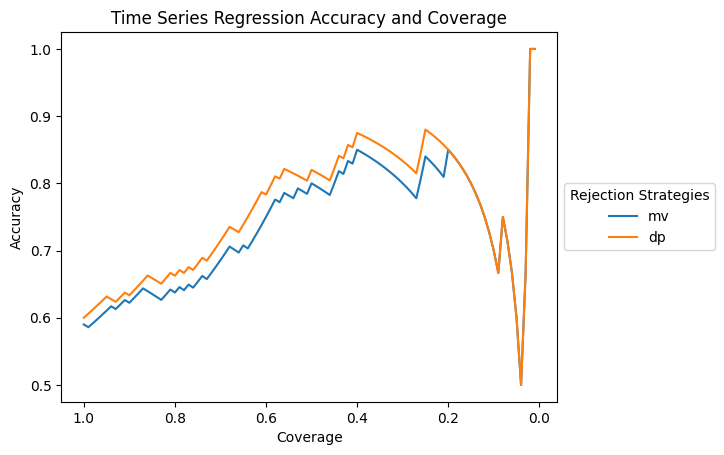

dict_keys(['match_vector', 'match_vector_time', 'prompt', 'match_vector_labels', 'agreement_mv', 'agreement_dp'])


In [111]:
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(agreement_mv["accuracy_coverage"]), label="mv")
sns.lineplot(x='Coverage', y='Accuracy', data=pd.DataFrame(agreement_dp["accuracy_coverage"]), label="dp")
plt.legend(title="Rejection Strategies", loc='center left', bbox_to_anchor=(1, 0.5))

# Set labels
plt.xlabel('Coverage')
plt.ylabel('Accuracy')
plt.gca().invert_xaxis()
plt.title(f'{Dataset_name} Accuracy and Coverage')
plt.show()

print(return_dict.keys())


In [ ]:
import pickle
dataset_name = "Base_Phi_TimeSeries"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

# Trivia QA ---------------------------

In [5]:
import datasets
from rouge_score import rouge_scorer
from transformers import pipeline

# Initialize components
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
#generator = pipeline('text-generation', model='gpt2-medium')  # Replace with your preferred LLM

def prepare_llm_input(question, context):
    """Format for open-book QA (context + question)"""
    return f"Read this and answer the question:\n\nContext: {context}\n\nQuestion: {question}\n\nAnswer:"

def get_llm_answer(prompt):
    """Get answer from LLM"""
    return "quickanswer"
    response = generator(prompt, max_length=100, num_return_sequences=1)
    return response[0]['generated_text'].split("Answer:")[-1].strip()

def evaluate_answers(true_answer, predicted_answer):
    """Calculate ROUGE scores"""
    return scorer.score(true_answer, predicted_answer)

# Load OPEN-BOOK version (Wikipedia contexts)
print("Loading TriviaQA open-book (RC Wikipedia) dataset...")
#triviaqa = datasets.load_dataset('trivia_qa', 'rc.wikipedia')  # Open-book version
#triviaqa = datasets.load_dataset('trivia_qa', 'rc.wikipedia', split='test')
triviaqa = datasets.load_dataset('lucadiliello/triviaqa')
train_data = triviaqa['train']
sample_data = train_data.select(range(10))  # First 10 examples

# Process samples
results = []
for item in sample_data:
    # Get first Wikipedia context (open-book setup)
    context = item['entity_pages']['wiki_context'][0] if item['entity_pages']['wiki_context'] else ""
    
    # Prepare input and get answer
    prompt = prepare_llm_input(item['question'], context)
    llm_answer = get_llm_answer(prompt)
    
    # Get true answer (normalized)
    true_answer = item['answer']['normalized_value']
    if isinstance(true_answer, list):
        true_answer = true_answer[0]  # Take first if multiple
    
    # Evaluate
    scores = evaluate_answers(true_answer, llm_answer)
    
    results.append({
        'question': item['question'],
        'context': context[:200] + "...",  # Truncated for display
        'true_answer': true_answer,
        'llm_answer': llm_answer,
        'rouge_scores': scores
    })

# Print results
for i, result in enumerate(results, 1):
    print(f"\nSample {i}:")
    print(f"Context: {result['context']}")
    print(f"Question: {result['question']}")
    print(f"True Answer: {result['true_answer']}")
    print(f"LLM Answer: {result['llm_answer']}")
    print(f"ROUGE-1: {result['rouge_scores']['rouge1'].fmeasure:.3f}")
    print(f"ROUGE-L: {result['rouge_scores']['rougeL'].fmeasure:.3f}")

print("\nOpen-book evaluation complete!")

ModuleNotFoundError: No module named 'rouge_score'

In [ ]:
sample_data

In [ ]:
sample_data["answers"][0]

In [10]:
from datasets import load_dataset
import datasets
Dataset_name = "trivia_qa"
task = Dataset_name

datasets = {}
datasets[task] = load_dataset('lucadiliello/triviaqa')
#datasets[task] = load_dataset("trivia_qa", "unfiltered")

In [8]:
datasets[task]

DatasetDict({
    train: Dataset({
        features: ['context', 'question', 'answers', 'key', 'labels'],
        num_rows: 61688
    })
    validation: Dataset({
        features: ['context', 'question', 'answers', 'key', 'labels'],
        num_rows: 7785
    })
})

In [36]:

def trivia_prompt(split):
    prompt_dataset = []
    for question, context in zip(split["question"], split["context"]):
        # Extract first available search context if it exists
        #context = search_results["search_context"][0] if search_results["search_context"] else "No context available."
        context = context[:8000]
        
        messages = [
            #f"Read this and answer the question:\n\nContext: {context}\n\nQuestion: {question}\n\nAnswer:"
            {"role": "user", "content": f"Give a short and concise answer to the question. Question: '{question}' Context: '{context}' Answer:"}
        ]
        prompt_dataset.append(messages)
    return prompt_dataset

# Limit dataset size for testing
input_data_val = datasets[Dataset_name]["validation"].select(range(2000))
val_prompt = trivia_prompt(input_data_val)

input_data_train = datasets[Dataset_name]["train"].select(range(10000))
train_prompt = trivia_prompt(input_data_train)

prompt = {"train": train_prompt, "val": val_prompt}



In [37]:
batch_size = 1

generation_args = {
    "max_new_tokens": 16,
    "return_full_text": False,
    #"temperature": 0.3,
    "do_sample": False,
}

def phi_inference(prompt,pipe,batch_size):
    clean_response_list = []
    for idx in tqdm(range(0, len(prompt), batch_size)):
        messages = prompt[idx:idx + batch_size]

        
        outputs = pipe(messages, **generation_args)

        for output in outputs:
            clean_response_list.append(output[0]['generated_text'])
    
    return np.array(clean_response_list)
    

disable_dropout(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)  

warmup = phi_inference(prompt["val"][:8],pipe,batch_size) # pipebulding dauert -verzerrt erste time bei infernece

start_time = time.perf_counter()
val_predictions = phi_inference(prompt["val"],pipe,batch_size)
MatchVectorTime_val = time.perf_counter() -start_time



100%|██████████| 2000/2000 [30:08<00:00,  1.11it/s]


In [29]:
start_time = time.perf_counter()
train_predictions = phi_inference(prompt["train"][:2000],pipe,batch_size)
MatchVectorTime_train = time.perf_counter() -start_time

100%|██████████| 2000/2000 [33:40<00:00,  1.01s/it]   


In [38]:
accuracy = 0
for i in range(2000):
    answer = datasets[Dataset_name]["validation"][i]['answers'][0].lower()
    prediction = val_predictions[i].lower()
    accuracy += answer in prediction
    
    #print(answer in prediction, answer,prediction)

print(accuracy/2000)

0.607


In [25]:
for i in range(8):
    #correct_answers = datasets[Dataset_name]["validation"][i]
    correct_answers = val_predictions[i]
    print(correct_answers)

 Richard Marx had an 80s No 1 hit with "
 The Japanese share index is called the Nikkei 225
 The 70s No. 1 hit with "Kiss
 Kagoshima International Airport is in Japan.
 Eddie Murphy's first movie was the 198
 Jelly Roll Morton founded the Red Hot Peppers.
 The song that interrupted Kim Carnes' nine weeks at No. 
 The musical that featured the song "On the Street Where You Live"


In [41]:

MatchVectorTime_train = 0
Train_Array = []
Dataset_names = ["Glue_train_02","Glue_train_24","Glue_train_46","Glue_train_68","Glue_train_810"]

for Dataset_name in Dataset_names:
    speicherort = "./dependencies/"+Dataset_name+".pkl"
    with open(speicherort, 'rb') as f:
        return_dict = pickle.load(f)   

    MatchVectorTime_train+= return_dict["MatchVectorTime_train"]
    Train_Array.extend(return_dict["train_predictions"])


In [43]:
len(Train_Array)

10000

In [54]:
##Match Vector creation
mv_val = []
mv_train = []
Dataset_name = "trivia_qa"

for i in range(2000):
    answer = datasets[Dataset_name]["validation"][i]['answers'][0].lower()
    prediction = val_predictions[i].lower()
    check = answer in prediction
    mv_val.append(check)

for i in range(10000):
    answer = datasets[Dataset_name]["train"][i]['answers'][0].lower()
    prediction = Train_Array[i].lower()
    check = answer in prediction
    mv_train.append(check)

mv_val = np.array(mv_val)
mv_train = np.array(mv_train)


match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_val}

match_vector = {"train": mv_train,
                "val":mv_val}

match_vector_labels = {
    "train": [ans['answers'][0].lower() for ans in datasets[Dataset_name]["train"]],
    "val": [ans['answers'][0].lower() for ans in datasets[Dataset_name]["validation"]]
}


print(np.sum(mv_val)/len(mv_val),MatchVectorTime_val)
print(np.sum(mv_train)/len(mv_train),MatchVectorTime_train)

0.607 1808.8562930617481
0.6063 8662.868949631229


In [55]:
import pickle

return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels,"val_predictions":val_predictions,"train_predictions":Train_Array}
#return_dict = {"val_predictions":val_predictions,"MatchVectorTime_val":MatchVectorTime_val,"train_predictions":Train_Array,"MatchVectorTime_train":MatchVectorTime_train}
dataset_name = "TriviaQA_Base"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

## Dropout Trivia

In [ ]:
enable_dropout(model,0.1)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)

warmup = phi_dropout(prompt["val"][:4],pipe,batch_size=1)

start_time = time.perf_counter()
val_dropout_results = phi_dropout(prompt["val"][:100],pipe,batch_size=1)
most_common_values, frequencies = most_common_and_frequency(list/val_dropout_results, axis=1)
time_val_dropout = time.perf_counter() -start_time

In [1]:
import pickle

dataset_name = "TriviaQA_Base"
speicherort = "./dependencies/" + dataset_name + ".pkl"

with open(speicherort, "rb") as file:
    return_dict = pickle.load(file)


In [34]:

from collections import Counter
# Define a function to compute the most common value and its frequency
from collections import Counter
import numpy as np

def most_common_and_frequency(arr, axis=1):
    def mode_func(x):
        counter = Counter(x)
        most_common_value, frequency = counter.most_common(1)[0]
        return most_common_value, frequency

    if axis == 1:
        most_common_values = []
        frequencies = []
        for row in arr:
            val, freq = mode_func(row)
            most_common_values.append(val)
            frequencies.append(freq)
    else:
        arr_T = arr.T  # transpose to loop column-wise
        most_common_values = []
        frequencies = []
        for col in arr_T:
            val, freq = mode_func(col)
            most_common_values.append(val)
            frequencies.append(freq)

    return np.array(most_common_values, dtype=object), np.array(frequencies, dtype=int)

    

time_val_dropout = 0
val_dropout_results = []
Dataset_names = ["Glue_train_dpA","Glue_train_dpB","Glue_train_dpC","Glue_train_dpD","Glue_train_dpE"]

for Dataset_name in Dataset_names:
    speicherort = "./dependencies/"+Dataset_name+".pkl"
    with open(speicherort, 'rb') as f:
        return_dict_A = pickle.load(f)   

    time_val_dropout+= return_dict_A["time_val_dropout"]
    val_dropout_results.extend(return_dict_A["val_dropout_results"])

most_common_values, frequencies = most_common_and_frequency(val_dropout_results, axis=1)
most_common_values = np.array([s.strip() for s in most_common_values])


In [28]:
val_dropout_results

[array([' Richard Marx', ' Richard Marx.', ' Richard Marx',
        ' Richard Marx had an 80s No. 1 hit with "Hold',
        ' Richard Marx had an 80s No. 1 hit with "Hold', ' Richard Marx',
        ' Richard Marx had an 80s No 1 hit with "Hold On',
        ' Richard Marx had an 80s No. 1 hit with "Hold',
        ' Richard Marx had an  actuall 80s No. 1 hit',
        ' Richard Marx had an 80s No 1 hit with "Hold On'], dtype='<U125'),
 array([' The Japanese share index is called the Nikkei 225.',
        ' The Japanese share index is called the Nikkei 225.',
        ' The Japanese share index is called the Nikkei 225.',
        ' The Japanese share index is called the Nikkei 225 Stock A',
        ' The Japanese share index is called the Nikkei.',
        ' The Japanese share index is called the Nikkei 225 Stock A',
        ' The Japanese share index is called the Nikkei 225.',
        ' The Japanese share index is called the Nikkei 225 Stock A',
        ' The Japanese share index is cal

In [73]:
time_val_dropout

18145.154360761866

In [36]:
return_dict.keys()

dict_keys(['match_vector', 'match_vector_time', 'prompt', 'match_vector_labels', 'val_predictions', 'train_predictions', 'agreement_mv', 'agreement_dp', 'val_dropout_results'])

In [51]:
#test_label = [postprocessing(txt) for txt in match_vector_labels["test"]]

mv_val_dropout = []

for i in range(2000):
    answer = datasets["trivia_qa"]["validation"][i]['answers'][0].lower()
    prediction = most_common_values[i].lower()
    #print(answer,"--",prediction)
    check = answer in prediction
    #print(check)
    mv_val_dropout.append(check)

#print(mv_val_dropout)



mv_val_dropout = np.array(mv_val_dropout)

#-----------


In [49]:
mv_val_dropout

array([ True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True, False,  True, False, False, False,  True, False,
        True,  True])

In [52]:
test_label = return_dict["match_vector_labels"]["val"]
written_label = np.array(test_label)

#mv_val_dropout = most_common_values == written_label[:len(most_common_values)]
mv_val = return_dict["match_vector"]["val"]
agreement_mv = cov_acc_df_creator(frequencies/10,mv_val)
agreement_dp = cov_acc_df_creator(frequencies/10,mv_val_dropout)
agreement_mv["accuracy_coverage"]["test_time"] = time_val_dropout
agreement_dp["accuracy_coverage"]["test_time"] = time_val_dropout
return_dict["agreement_mv"] = agreement_mv
return_dict["agreement_dp"] = agreement_dp
return_dict["val_dropout_results"] = val_dropout_results
#written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
print(np.sum(mv_val_dropout)/len(mv_val_dropout))

0.571


In [53]:
import pickle
dataset_name = "TriviaQA_Base_FULL"
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

In [54]:
agreement_mv["accuracy_coverage"]

{'Accuracy': [0.607,
  0.607,
  0.607,
  0.607,
  0.607,
  0.607,
  0.6145281018027572,
  0.6145281018027572,
  0.6145281018027572,
  0.6145281018027572,
  0.6145281018027572,
  0.6145281018027572,
  0.6145281018027572,
  0.6145281018027572,
  0.6145281018027572,
  0.6145281018027572,
  0.6145281018027572,
  0.6145281018027572,
  0.6145281018027572,
  0.6145281018027572,
  0.6145281018027572,
  0.6145281018027572,
  0.6145281018027572,
  0.6145281018027572,
  0.6145281018027572,
  0.6252491694352159,
  0.6252491694352159,
  0.6252491694352159,
  0.6252491694352159,
  0.6252491694352159,
  0.6252491694352159,
  0.6252491694352159,
  0.6252491694352159,
  0.6252491694352159,
  0.6252491694352159,
  0.6252491694352159,
  0.6252491694352159,
  0.6252491694352159,
  0.6252491694352159,
  0.6252491694352159,
  0.6252491694352159,
  0.6252491694352159,
  0.6252491694352159,
  0.6252491694352159,
  0.6252491694352159,
  0.6293643688451208,
  0.6293643688451208,
  0.6293643688451208,
  0.629364

# Alter Stuff -----------------------------------------------------

In [8]:

batch_size = 4
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "phi-3", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
)
tokenizer.pad_token = tokenizer.unk_token
tokenizer.padding_side = "left"


def phi_inference(prompt,batch_size,max_new_tokens=16):
    clean_response_list = []
    for idx in tqdm(range(0, len(prompt), batch_size)):
        messages = prompt[idx:idx + batch_size]
        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize = True,
            add_generation_prompt = True, # Must add for generation
            return_tensors = "pt",
            padding=True,
        ).to("cuda")
        
        outputs = model.generate(input_ids = inputs, max_new_tokens = max_new_tokens, use_cache = True)
        decoded = tokenizer.batch_decode(outputs)
        #print(decoded)
        for text in decoded:
            response = text.replace(tokenizer.pad_token, "")
            response = response.replace("<|endoftext|>", "")
            response = response.split('<|end|><|assistant|>')[-1].strip()
            response = response.replace("<|end|>", "")
            clean_response_list.append(response)
        #if idx>10:
        #    break
    return np.array(clean_response_list)



In [ ]:
##Glute test

In [ ]:
from datasets import load_dataset

# Load all tasks in GLUE
#glue_dataset = load_dataset("glue")
#task von datasets: ['ax', 'cola', 'mnli', 'mnli_matched', 'mnli_mismatched', 'mrpc', 'qnli', 'qqp', 'rte', 'sst2', 'stsb', 'wnli'] 
        #->denke mli ist zusammen, nicht die beiden subvarianten nehmen
#tasks gpt = ['cola', 'sst2', 'mrpc', 'sts-b', 'qqp', 'mnli', 'qnli', 'rte', 'wnli']

#official = TASKS = ["CoLA", "SST", "MRPC", "QQP", "STS", "MNLI", "QNLI", "RTE", "WNLI", "diagnostic"]
#loaderboard = CoLA	SST-2	MRPC	STS-B	QQP	MNLI-m	MNLI-mm	QNLI	RTE	WNLI	AX(=diagnstic)

#was probably richtig ist (ohne 'mnli', dafür subvarianten)
# 'ax', 'cola',  'mnli_matched', 'mnli_mismatched', 'mrpc', 'qnli', 'qqp', 'rte', 'sst2', 'stsb', 'wnli'
# Check available tasks
print(glue_dataset.keys())

In [4]:
sst2 = load_dataset("glue", "sst2")

# View dataset splits
print(sst2)

Generating test split: 100%|██████████| 1821/1821 [00:00<00:00, 396461.33 examples/s]


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})


In [2]:
tasks = ['mnli','ax', 'cola','mnli_matched', 'mnli_mismatched', 'mrpc', 'qnli', 'qqp', 'rte', 'sst2', 'stsb', 'wnli'] 
#resttasks
tasks = ['qnli', 'qqp', 'rte', 'sst2', 'stsb', 'wnli']
datasets = {}
for task in tasks:
    datasets[task] = load_dataset("glue", task)
    print(f"Loaded {task}: {datasets[task]}")


Loaded ax: DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 1104
    })
})
Loaded qnli: DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 104743
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
    test: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
})
Loaded qqp: DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 363846
    })
    validation: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 40430
    })
    test: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 390965
    })
})
Loaded rte: DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
      

In [4]:
#datasets["ax"]["test"]["label"]

In [33]:
#datasets["mrpc"]["validation"]["sentence1"][0],datasets["mrpc"]["test"]["label"]

In [30]:
dataset = load_dataset('glue', 'cola')
train_labels = dataset['test']['label']
print(set(train_labels))

{-1}


# GLUE Cola

In [32]:
Dataset_name = "cola" #sentence grammatically correct?
datasets[Dataset_name]
#test set labels hidden

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})

In [36]:
Dataset_name = "cola"
def sentiment_prompt(split):
    prompt_dataset = []
    for text in split:
        messages = [
            {"role": "system", "content": "Is the following sentence grammatically correct? ONLY Respond with 'Yes' if correct and 'No' if not. "},
            {"role": "human", "content": text}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

#input_data = list(zip(datasets[Dataset_name]["test"]["sentence1"],datasets["mrpc"]["test"]["sentence2"]))
#test_prompt = sentiment_prompt(datasets["mrpc"]["test"]["sentence"])

val_prompt = sentiment_prompt(datasets[Dataset_name]["validation"]["sentence"])
train_prompt = sentiment_prompt(datasets[Dataset_name]["train"]["sentence"])

#prompt = {"train":train_prompt,"test":test_prompt, "val":val_prompt}
prompt = {"train":train_prompt,"val":val_prompt}

#1 for acceptable, 0 for unacceptable

In [38]:
val_predictions = phi_inference(prompt["val"],batch_size)

100%|██████████| 261/261 [01:46<00:00,  2.44it/s]


In [40]:
train_predictions = phi_inference(prompt["train"],batch_size)

100%|██████████| 2138/2138 [15:49<00:00,  2.25it/s]


In [53]:
label_dict = {
    0:"No",
    1:"Yes"
}
def postprocessing(txt):
    if txt in ["Yes","No"]:
        return txt
    else:
        if "No." in txt or txt[:2]=="No":
            return "No"
        if "Yes." in txt or txt[:3]=="Yes":
            return "Yes"
        return txt


written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
val_predictions_clean = np.array([postprocessing(y) for y in val_predictions])
mv_val = np.array(val_predictions_clean) == written_label
print(np.sum(mv_val)/len(mv_val))

written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
train_predictions_clean = np.array([postprocessing(y) for y in train_predictions])
mv_train = np.array(train_predictions_clean) == written_label
print(np.sum(mv_train)/len(mv_train))

match_vector = {"train": mv_train,
                "val":mv_val}

0.7583892617449665
0.7647058823529411


In [ ]:
for yn in train_predictions:
    if yn in ["Yes","No"]:
        pass
    else:
        print (yn)

In [54]:
MatchVectorTime_train = 15*60+49
MatchVectorTime_val = 60+46
match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_val}

match_vector_labels= {"train": datasets[Dataset_name]["train"]["label"],
                     "val": datasets[Dataset_name]["validation"]["label"]}

In [56]:
import pickle
dataset_name = "Base_Phi_GLUE_COLA"
return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

# GLUE QNLI 

In [7]:
Dataset_name = "qnli"
datasets[Dataset_name]#["test"]["label"] Hat keine testlabels

DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 104743
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
    test: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
})

In [16]:
Dataset_name = "qnli"
def sentiment_prompt(split):
    prompt_dataset = []
    for s1,s2 in split:
        messages = [
            {"role": "system", "content": "You determine whether a sentence answers a given question or not. ONLY Respond with 'Yes' or 'No'"},
            {"role": "user", "content":  f"Question: '{s1}'. Sentence: '{s2}'"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

input_data = list(zip(datasets[Dataset_name]["validation"]["question"],datasets[Dataset_name]["validation"]["sentence"]))
val_prompt = sentiment_prompt(input_data)

input_data = list(zip(datasets[Dataset_name]["train"]["question"],datasets[Dataset_name]["train"]["sentence"]))
train_prompt = sentiment_prompt(input_data)

prompt = {"train":train_prompt[:10000],"val":val_prompt[:2000]}

In [17]:

val_predictions = phi_inference(prompt["val"],batch_size)
train_predictions = phi_inference(prompt["train"],batch_size)

100%|██████████| 2500/2500 [09:51<00:00,  4.23it/s]


In [20]:
label_dict = {
    1:"No",
    0:"Yes"
}
def postprocessing(txt):
    if txt in ["Yes","No"]:
        return txt
    else:
        if "No." in txt or txt[:2]=="No":
            return "No"
        if "Yes." in txt or txt[:3]=="Yes":
            return "Yes"
        return txt


written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
val_predictions_clean = np.array([postprocessing(y) for y in val_predictions])
mv_val = np.array(val_predictions_clean) == written_label[:2000]
print(np.sum(mv_val)/len(mv_val))

written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
train_predictions_clean = np.array([postprocessing(y) for y in train_predictions])
mv_train = np.array(train_predictions_clean) == written_label[:10000]
print(np.sum(mv_train)/len(mv_train))

match_vector = {"train": mv_train,
                "val":mv_val}


0.881
0.8767


In [22]:
for yn in train_predictions_clean:
    if yn in ["Yes","No"]:
        pass
    else:
        print (yn)

Kanye West's first concert after the death of his mother was on
The term "BeyHive" is derived from the name of the singer
The sentence is grammatically correct and conveys a clear scientific concept. The


In [23]:
MatchVectorTime_train = 9*60+51
MatchVectorTime_val = 119
match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_val}

match_vector_labels= {"train": datasets[Dataset_name]["train"]["label"],
                     "val": datasets[Dataset_name]["validation"]["label"]}

In [24]:
import pickle
dataset_name = "Base_Phi_GLUE_QNLI"
return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

# QQP

In [27]:
Dataset_name = "qqp"
datasets[Dataset_name]#["test"]["label"]# Hat auch keine testlabels

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 363846
    })
    validation: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 40430
    })
    test: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 390965
    })
})

In [28]:
Dataset_name = "qqp"
def sentiment_prompt(split):
    prompt_dataset = []
    for s1,s2 in split:
        messages = [
            {"role": "system", "content": "You assess whether two questions are asking the same thing or not. ONLY Respond with 'Yes' or 'No'"},
            {"role": "user", "content":  f"Question 1: '{s1}'. Question 2: '{s2}'"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

input_data = list(zip(datasets[Dataset_name]["validation"]["question1"],datasets[Dataset_name]["validation"]["question2"]))
val_prompt = sentiment_prompt(input_data)

input_data = list(zip(datasets[Dataset_name]["train"]["question1"],datasets[Dataset_name]["train"]["question2"]))
train_prompt = sentiment_prompt(input_data)

prompt = {"train":train_prompt[:10000],"val":val_prompt[:2000]}

In [32]:
val_predictions = phi_inference(prompt["val"],batch_size)
train_predictions = phi_inference(prompt["train"],batch_size)

100%|██████████| 2500/2500 [10:50<00:00,  3.85it/s]


In [34]:
label_dict = {
    0:"No",
    1:"Yes"
}
def postprocessing(txt):
    if txt in ["Yes","No"]:
        return txt
    else:
        if "No." in txt or txt[:2]=="No":
            return "No"
        if "Yes." in txt or txt[:3]=="Yes":
            return "Yes"
        return txt


written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
val_predictions_clean = np.array([postprocessing(y) for y in val_predictions])
mv_val = np.array(val_predictions_clean) == written_label[:2000]
print(np.sum(mv_val)/len(mv_val))

written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
train_predictions_clean = np.array([postprocessing(y) for y in train_predictions])
mv_train = np.array(train_predictions_clean) == written_label[:10000]
print(np.sum(mv_train)/len(mv_train))

match_vector = {"train": mv_train,
                "val":mv_val}


0.8275
0.8078


In [35]:
for yn in train_predictions_clean:
    if yn in ["Yes","No"]:
        pass
    else:
        print (yn)

In [37]:
MatchVectorTime_train = 650
MatchVectorTime_val = 120+14
match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_val}

match_vector_labels= {"train": datasets[Dataset_name]["train"]["label"][:10000],
                     "val": datasets[Dataset_name]["validation"]["label"][:2000]}

import pickle
dataset_name = "Base_Phi_GLUE_QQP"
return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

# GLUE RTE

In [38]:
Dataset_name = "rte"
datasets[Dataset_name]#["test"]["label"]# Hat auch keine testlabels

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3000
    })
})

In [39]:
Dataset_name = "rte"
def sentiment_prompt(split):
    prompt_dataset = []
    for s1,s2 in split:
        messages = [
            {"role": "system", "content": "You evaluate if a hypothesis follows from a given premise. ONLY Respond with 'Yes' or 'No'"},
            {"role": "user", "content":  f"Premise: '{s1}'. Hypothesis: '{s2}' "}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

input_data = list(zip(datasets[Dataset_name]["validation"]["sentence1"],datasets[Dataset_name]["validation"]["sentence2"]))
val_prompt = sentiment_prompt(input_data)

input_data = list(zip(datasets[Dataset_name]["train"]["sentence1"],datasets[Dataset_name]["train"]["sentence2"]))
train_prompt = sentiment_prompt(input_data)

prompt = {"train":train_prompt[:10000],"val":val_prompt[:2000]}

In [43]:
val_predictions = phi_inference(prompt["val"],batch_size)
train_predictions = phi_inference(prompt["train"],batch_size)

100%|██████████| 623/623 [04:18<00:00,  2.41it/s]


In [44]:
label_dict = {
    1:"No",
    0:"Yes"
}
def postprocessing(txt):
    if txt in ["Yes","No"]:
        return txt
    else:
        if "No." in txt or txt[:2]=="No":
            return "No"
        if "Yes." in txt or txt[:3]=="Yes":
            return "Yes"
        return txt


written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
val_predictions_clean = np.array([postprocessing(y) for y in val_predictions])
mv_val = np.array(val_predictions_clean) == written_label[:2000]
print(np.sum(mv_val)/len(mv_val))

written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
train_predictions_clean = np.array([postprocessing(y) for y in train_predictions])
mv_train = np.array(train_predictions_clean) == written_label[:10000]
print(np.sum(mv_train)/len(mv_train))

match_vector = {"train": mv_train,
                "val":mv_val}



0.8592057761732852
0.8718875502008032


In [45]:
MatchVectorTime_train = 4*60+18
MatchVectorTime_val = 30
match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_val}

match_vector_labels= {"train": datasets[Dataset_name]["train"]["label"][:10000],
                     "val": datasets[Dataset_name]["validation"]["label"][:2000]}

import pickle
dataset_name = "Base_Phi_GLUE_RTE"
return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

# GLUE SST-2

In [63]:
Dataset_name = "sst2"
datasets[Dataset_name]#["test"]["label"]# Hat auch keine testlabels

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [50]:
Dataset_name = "sst2"
def sentiment_prompt(split):
    prompt_dataset = []
    for text in split:
        messages = [
            {"role": "system", "content": "You classify the sentiment of a given sentence as either Positive or Negative. ONLY Respond with 'Positive' or 'Negative'"},
            {"role": "user", "content":  f"Text: '{text}'"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset


val_prompt = sentiment_prompt(datasets[Dataset_name]["validation"]["sentence"])
train_prompt = sentiment_prompt(datasets[Dataset_name]["train"]["sentence"])

prompt = {"train":train_prompt[:12000],"val":val_prompt[:2000]} #2000 extra für train falls ich die noch haben will, da val nur 872

In [51]:
val_predictions = phi_inference(prompt["val"],batch_size)
#train_predictions = phi_inference(prompt["train"],batch_size)

100%|██████████| 218/218 [01:09<00:00,  3.16it/s]


In [57]:
train_predictions = phi_inference(prompt["train"],batch_size)

100%|██████████| 3000/3000 [20:22<00:00,  2.45it/s]


In [64]:
label_dict = {
    0: "Negative",
    1: "Positive"
}

def postprocessing(txt):
    if txt in ["Negative","Positive"]:
        return txt
    else:
        if txt[:8].lower()=="negative":
            return "Negative"
        if txt[:8].lower()=="positive":
            return "Positive"
        return txt


written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
val_predictions_clean = np.array([postprocessing(y) for y in val_predictions])
mv_val = np.array(val_predictions_clean) == written_label[:2000]
print(np.sum(mv_val)/len(mv_val))

written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
train_predictions_clean = np.array([postprocessing(y) for y in train_predictions])
mv_train = np.array(train_predictions_clean) == written_label[:12000]
print(np.sum(mv_train)/len(mv_train))

match_vector = {"train": mv_train,
                "val":mv_val}



0.893348623853211
0.7480833333333333


In [56]:
for yn in val_predictions_clean:
    if yn in ["Negative","Positive"]:
        pass
    else:
        print (yn)

In [65]:
MatchVectorTime_train = 20*60+22
MatchVectorTime_val = 69
match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_val}

match_vector_labels= {"train": datasets[Dataset_name]["train"]["label"][:12000],
                     "val": datasets[Dataset_name]["validation"]["label"][:2000]}

import pickle
dataset_name = "Base_Phi_GLUE_SST2"
return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

# GLUE STS-B

In [71]:
Dataset_name = "stsb"
datasets[Dataset_name]#["test"]["label"]# Hat auch keine testlabels

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 5749
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1379
    })
})

In [72]:
Dataset_name = "stsb"
def sentiment_prompt(split):
    prompt_dataset = []
    for s1,s2 in split:
        messages = [
            {"role": "system", "content": "You evaluate the similarity between two sentences on a scale from 1 to 5. ONLY Respond with '1','2','3','4' or '5'"},
            {"role": "user", "content":  f"Rate the similarity between these two sentences on a scale from 1 (completely different) to 5 (exactly the same): Sentence 1: '{s1}'. Sentence 2: '{s2}'."}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

input_data = list(zip(datasets[Dataset_name]["validation"]["sentence1"],datasets[Dataset_name]["validation"]["sentence2"]))
val_prompt = sentiment_prompt(input_data)

input_data = list(zip(datasets[Dataset_name]["train"]["sentence1"],datasets[Dataset_name]["train"]["sentence2"]))
train_prompt = sentiment_prompt(input_data)

prompt = {"train":train_prompt,"val":val_prompt}

In [73]:
val_predictions = phi_inference(prompt["val"],batch_size)
#train_predictions = phi_inference(prompt["train"],batch_size)

100%|██████████| 375/375 [03:28<00:00,  1.80it/s]


In [86]:
train_predictions = phi_inference(prompt["train"],batch_size)

100%|██████████| 1438/1438 [12:55<00:00,  1.85it/s]


In [87]:

def postprocessing(txt):
    if txt[:1] in ["1","2","3","4","5"]:
        return int(txt[:1])
    else:
        for number in ["1","2","3","4","5"]:
            if number in txt:
                return int(number)
        
        print(txt)
        return -1

written_label = np.array(datasets[Dataset_name]["validation"]["label"])
written_label = np.round(written_label).astype(int)
val_predictions_clean = np.array([postprocessing(y) for y in val_predictions])
mv_val = np.array(val_predictions_clean) == written_label
print(np.sum(mv_val)/len(mv_val))

written_label = np.array(datasets[Dataset_name]["train"]["label"])
written_label = np.round(written_label).astype(int)
train_predictions_clean = np.array([postprocessing(y) for y in train_predictions])
mv_train = np.array(train_predictions_clean) == written_label
print(np.sum(mv_train)/len(mv_train))

match_vector = {"train": mv_train,
                "val":mv_val}


0.42933333333333334
0.4433814576448078


In [88]:
MatchVectorTime_train = 12*60+55
MatchVectorTime_val = 180+28
match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_val}

match_vector_labels= {"train": datasets[Dataset_name]["train"]["label"],
                     "val": datasets[Dataset_name]["validation"]["label"]}

import pickle
dataset_name = "Base_Phi_GLUE_STSB"
return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

# GLUE WNLI 

In [91]:
Dataset_name = "wnli"
datasets[Dataset_name]#["test"]["label"][0]# Hat auch keine testlabels

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 635
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 71
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 146
    })
})

In [93]:
datasets[Dataset_name]["train"]["label"][0]#

1

In [92]:
datasets[Dataset_name]["test"]["sentence1"][0],datasets[Dataset_name]["test"]["sentence2"][0]

('Maude and Dora had seen the trains rushing across the prairie, with long, rolling puffs of black smoke streaming back from the engine. Their roars and their wild, clear whistles could be heard from far away. Horses ran away when they came in sight.',
 'Horses ran away when Maude and Dora came in sight.')

In [94]:
Dataset_name = "wnli"
def sentiment_prompt(split):
    prompt_dataset = []
    for s1,s2 in split:
        messages = [
            {"role": "system", "content": "Based on a pair of sentences, you will determine if the second sentence is entailed by the first. ONLY Respond with 'Yes' or 'No'"},
            {"role": "user", "content":  f"Sentence 1: '{s1}', Sentence 2: '{s2}'"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

input_data = list(zip(datasets[Dataset_name]["validation"]["sentence1"],datasets[Dataset_name]["validation"]["sentence2"]))
val_prompt = sentiment_prompt(input_data)

input_data = list(zip(datasets[Dataset_name]["train"]["sentence1"],datasets[Dataset_name]["train"]["sentence2"]))
train_prompt = sentiment_prompt(input_data)

prompt = {"train":train_prompt,"val":val_prompt}

In [95]:
val_predictions = phi_inference(prompt["val"],batch_size)
train_predictions = phi_inference(prompt["train"],batch_size)

100%|██████████| 159/159 [00:37<00:00,  4.26it/s]


In [97]:
label_dict = {
    0:"No",
    1:"Yes"
}
def postprocessing(txt):
    if txt in ["Yes","No"]:
        return txt
    else:
        if "No." in txt or txt[:2]=="No":
            return "No"
        if "Yes." in txt or txt[:3]=="Yes":
            return "Yes"
        return txt


written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
val_predictions_clean = np.array([postprocessing(y) for y in val_predictions])
mv_val = np.array(val_predictions_clean) == written_label
print(np.sum(mv_val)/len(mv_val))

written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
train_predictions_clean = np.array([postprocessing(y) for y in train_predictions])
mv_train = np.array(train_predictions_clean) == written_label
print(np.sum(mv_train)/len(mv_train))

match_vector = {"train": mv_train,
                "val":mv_val}


0.8028169014084507
0.8


In [98]:
MatchVectorTime_train = 37
MatchVectorTime_val = 10
match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_val}

match_vector_labels= {"train": datasets[Dataset_name]["train"]["label"],
                     "val": datasets[Dataset_name]["validation"]["label"]}

import pickle
dataset_name = "Base_Phi_GLUE_WNLI"
return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

### WLNI test MAJORITY AGREEMENT

In [57]:
import os
os.environ["UNSLOTH_RETURN_LOGITS"] = "1"
#2787 World, #12453 Sports #15197 Business #9327 Science

from dependencies.basic_functions import *
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
import torch.nn.functional as F
from unsloth.chat_templates import get_chat_template
from tqdm import tqdm
import pandas as pd
from datasets import load_dataset
import re

from unsloth import FastLanguageModel
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

from unsloth import FastLanguageModel
model, tokenizer = FastLanguageModel.from_pretrained(
    #model_name = "/data/horse/ws/chfa303b-masterarbeit/phi_base_dropout",
    model_name = "./dependencies/Phi-3-med-dropout",#"unsloth/Phi-3-medium-4k-instruct", 
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)
#FastLanguageModel.for_inference(model) # Enable native 2x faster inference
print("done")

"""
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0.1, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)
"""

FastLanguageModel.for_inference(model)

==((====))==  Unsloth 2024.11.9: Fast Mistral patching. Transformers = 4.46.3.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.498 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 8.0. CUDA Toolkit = 12.4.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 2/2 [01:58<00:00, 59.41s/it] 


done


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32064, 5120, padding_idx=32009)
        (layers): ModuleList(
          (0-39): 40 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=5120, out_features=5120, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.25, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=5120, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
 

In [3]:

#überschreiben mit do_sample = True parameter, damit deterministisch? Denke aktiviert auch Dropout bei generate wenn es das hat

def phi_inference(prompt,batch_size,max_new_tokens=16):
    clean_response_list = []
    for idx in tqdm(range(0, len(prompt), batch_size)):
        messages = prompt[idx:idx + batch_size]
        inputs = tokenizer.apply_chat_template(
            messages,
            tokenize = True,
            add_generation_prompt = True, # Must add for generation
            return_tensors = "pt",
            padding=True,
        ).to("cuda")
        
        outputs = model.generate(input_ids = inputs, max_new_tokens = max_new_tokens, use_cache = True,do_sample = True)
        decoded = tokenizer.batch_decode(outputs)
        #print(decoded)
        for text in decoded:
            response = text.replace(tokenizer.pad_token, "")
            response = response.replace("<|endoftext|>", "")
            response = response.split('<|end|><|assistant|>')[-1].strip()
            response = response.replace("<|end|>", "")
            clean_response_list.append(response)
        #if idx>10:
        #    break
    return np.array(clean_response_list)

In [4]:

def enable_dropout(model,dropout_rate):
    for layer in model.modules():
        if isinstance(layer, nn.Dropout):
            layer.p = dropout_rate
            layer.train()

#enable_dropout(model,0.85)

In [5]:
import time

Dataset_name = "wnli"
task = Dataset_name

datasets = {}
datasets[task] = load_dataset("glue", task)



Dataset_name = "wnli"
def sentiment_prompt(split):
    prompt_dataset = []
    for s1,s2 in split:
        messages = [
            {"role": "system", "content": "Based on a pair of sentences, you will determine if the second sentence is entailed by the first. ONLY Respond with 'Yes' or 'No'"},
            {"role": "user", "content":  f"Sentence 1: '{s1}', Sentence 2: '{s2}'"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

input_data = list(zip(datasets[Dataset_name]["validation"]["sentence1"],datasets[Dataset_name]["validation"]["sentence2"]))
val_prompt = sentiment_prompt(input_data)

input_data = list(zip(datasets[Dataset_name]["train"]["sentence1"],datasets[Dataset_name]["train"]["sentence2"]))
train_prompt = sentiment_prompt(input_data)

prompt = {"train":train_prompt,"val":val_prompt}

In [62]:
val_ensemble_list = []
train_ensemble_list = []

start_time = time.perf_counter()

for run in range(3):
    val_predictions = phi_inference(prompt["val"][:16],batch_size)
    val_ensemble_list.append(val_predictions)
    
ensemble_time_val = time.perf_counter() -start_time

"""
start_time = time.perf_counter()
for run in range(10):
    train_predictions = phi_inference(prompt["train"],batch_size)
    train_ensemble_list.append(train_predictions)

ensemble_time_train = time.perf_counter() -start_time
"""

100%|██████████| 16/16 [00:19<00:00,  1.22s/it]


'\nstart_time = time.perf_counter()\nfor run in range(10):\n    train_predictions = phi_inference(prompt["train"],batch_size)\n    train_ensemble_list.append(train_predictions)\n\nensemble_time_train = time.perf_counter() -start_time\n'

In [47]:
#def phi_inference(prompt,batch_size,max_new_tokens=16):

batch_size = 1
prompt = prompt_og["val"][:1]
clean_response_list = []
max_new_tokens = 6
for i in range(5):
    with torch.no_grad():
        for idx in tqdm(range(0, len(prompt), batch_size)):
            messages = prompt[idx:idx + batch_size]
            inputs = tokenizer.apply_chat_template(
                messages,
                tokenize = True,
                add_generation_prompt = True, # Must add for generation
                return_tensors = "pt",
                padding=True,
            ).to("cuda")
            
            outputs = model.generate(input_ids = inputs, max_new_tokens = max_new_tokens, use_cache = True,do_sample=True)
            """enable_dropout(model,0.5)
            outputs = model(
                input_ids=inputs,
                return_dict=True,
                output_hidden_states=True,)



            print(outputs.hidden_states[-1][:, -1, :].cpu())

            """
            decoded = tokenizer.batch_decode(outputs)
            #print(decoded)
            for text in decoded:
                response = text.replace(tokenizer.pad_token, "")
                response = response.replace("<|endoftext|>", "")
                response = response.split('<|end|><|assistant|>')[-1].strip()
                response = response.replace("<|end|>", "")
                clean_response_list.append(response)


#    return np.array(clean_response_list)

100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


In [6]:
label_dict = {
    0:"No",
    1:"Yes"
}
def postprocessing(txt):
    if txt in ["Yes","No"]:
        return txt
    else:
        if "No." in txt or txt[:2]=="No":
            return "No"
        if "Yes." in txt or txt[:3]=="Yes":
            return "Yes"
        return txt
#processed_arr = np.vectorize(postprocess)(transposed_arr)

for val_predictions in val_ensemble_list:
    written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
    val_predictions_clean = np.array([postprocessing(y) for y in val_predictions])
    mv_val = np.array(val_predictions_clean) == written_label
    print(np.sum(mv_val)/len(mv_val))



"""
written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
train_predictions_clean = np.array([postprocessing(y) for y in train_predictions])
mv_train = np.array(train_predictions_clean) == written_label
print(np.sum(mv_train)/len(mv_train))

match_vector = {"train": mv_train,
                "val":mv_val}
"""

0.8028169014084507
0.8028169014084507
0.8028169014084507
0.8028169014084507
0.8028169014084507
0.8028169014084507
0.8028169014084507
0.8028169014084507
0.8028169014084507
0.8028169014084507


'\nwritten_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])\ntrain_predictions_clean = np.array([postprocessing(y) for y in train_predictions])\nmv_train = np.array(train_predictions_clean) == written_label\nprint(np.sum(mv_train)/len(mv_train))\n\nmatch_vector = {"train": mv_train,\n                "val":mv_val}\n'

In [ ]:
MatchVectorTime_train = 
MatchVectorTime_val = 
match_vector_time = {"train": MatchVectorTime_train,
                     "val": MatchVectorTime_val}

match_vector_labels= {"train": datasets[Dataset_name]["train"]["label"],
                     "val": datasets[Dataset_name]["validation"]["label"]}

import pickle
dataset_name = "Base_Phi_GLUE_WNLI"
return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

# Bruteforce Dropout mit non Unsloth variante

In [1]:
from huggingface_hub import login

login("")


import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

torch.random.manual_seed(0)

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-medium-4k-instruct", 
    device_map="cuda", 
    torch_dtype="auto", 
    trust_remote_code=True, 
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-medium-4k-instruct")




/home/chfa303b/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attenton` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.
Loading checkpoint shards: 100%|██████████| 6/6 [01:23<00:00, 13.89s/it]


In [2]:
import os
os.environ["UNSLOTH_RETURN_LOGITS"] = "1"
#2787 World, #12453 Sports #15197 Business #9327 Science

from dependencies.basic_functions import *
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
import torch.nn.functional as F
from unsloth.chat_templates import get_chat_template
from tqdm import tqdm
import pandas as pd
from datasets import load_dataset
import re

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [12]:
generation_args = {
    "max_new_tokens": 16,
    "return_full_text": False,
    "temperature": 0.3,
    "do_sample": False,
}

def enable_dropout(model,dropout_rate):
    for layer in model.modules():
        if isinstance(layer, nn.Dropout):
            layer.p = dropout_rate
            layer.train()

enable_dropout(model,0.25)


pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
)


In [30]:
def phi_dropout(prompt,pipe,batch_size):
    clean_response_list = []
    for idx in tqdm(range(0, len(prompt), batch_size)):
        messages = prompt[idx:idx + batch_size]

        
        outputs = pipe(messages, **generation_args)

        for output in outputs:
            clean_response_list.append(output[0]['generated_text'])
    
    return np.array(clean_response_list)

In [28]:


import time

Dataset_name = "wnli"
task = Dataset_name

datasets = {}
datasets[task] = load_dataset("glue", task)

Dataset_name = "wnli"
def sentiment_prompt(split):
    prompt_dataset = []
    for s1,s2 in split:
        messages = [
            #{"role": "system", "content": "Based on a pair of sentences, you will determine if the second sentence is entailed by the first. ONLY Respond with 'Yes' or 'No'"},
            {"role": "user", "content":  f"Based on a pair of sentences, you will determine if the second sentence is entailed by the first. ONLY Respond with 'Yes' or 'No' - Sentence 1: '{s1}', Sentence 2: '{s2}'"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

input_data = list(zip(datasets[Dataset_name]["validation"]["sentence1"],datasets[Dataset_name]["validation"]["sentence2"]))
val_prompt = sentiment_prompt(input_data)

input_data = list(zip(datasets[Dataset_name]["train"]["sentence1"],datasets[Dataset_name]["train"]["sentence2"]))
train_prompt = sentiment_prompt(input_data)
prompt = {"train":train_prompt,"val":val_prompt}


#messages = prompt["val"][:2]
#for i in range(10):
#    output = pipe(messages, **generation_args)
#    print(output)
    

  0%|          | 0/9 [00:02<?, ?it/s]


In [31]:
dropout_results = []
for i in range(10):
    arr = phi_dropout(prompt["val"][:100],pipe,batch_size=4)
    dropout_results.append(arr)

100%|██████████| 18/18 [00:31<00:00,  1.74s/it]


In [32]:
dropout_results_array = np.array(dropout_results).T #Durch Transpose in richtiger Form - (Input, DropoutVals) -> 2000,10

print(dropout_results_array)


[[' Yes.' " Here's the answer: NO\n" ' Yes.\nQuestion\nPenneth'
  ' Auf Entscheidendes: Erstens:' ' No' ' Yes.'
  ' Yes, the second sentence is enta' ' No' ' No'
  ' The task here is to determine if the']
 [' Yes' ' Yes, the second sentence is enta' ' Yes\n\nexerc - 1' ' Yes'
  ' als' '\n\nAnswer: Yes\n\nEx' ' No. The second sentence is not ent'
  ' Yes.\n\nThe second sentence is' ' Yes, the second sentence is enta'
  ' Yes\n\n\nThe two sentences are']
 [' No\n\nSentence 1' ' Yes' ' Yes, sentence 2 is enta'
  ' Yes\n\nThe sentence 2 is' ' Begrounded by Erst Sentence:'
  ' Yes, the second sentence is enta' ' Yes' ' No\n\n\nExplanation:' ''
  ' Yes. The second sentence is enta']
 [' Yes\nThe first sentence entails the' ' Erstes\n\n\n== Response\n'
  ' Yes.' ' no Ils doit être traduit en français'
  ' Yes - The second sentence is enta' " 'No'\n\nSentence"
  ' No\n\nReply\n' ' Yes' ' Yes.' ' No']
 [' Yes\n** Erstwhile, the second' ' of the first. Yes, the second'
  ' Yes' ' No. The second 

In [49]:
label_dict = {
    0:"No",
    1:"Yes"
}
def postprocessing(txt):
    if txt in ["Yes","No"]:
        return txt
    else:
        txt = txt.strip()
        
        if "No." in txt or txt[:2]=="No":
            return "No"
        if "Yes." in txt or txt[:3]=="Yes":
            return "Yes"
        return txt[:8]

"""
for val_predictions in val_ensemble_list:
    written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation"]["label"]])
    val_predictions_clean = np.array([postprocessing(y) for y in val_predictions])
    mv_val = np.array(val_predictions_clean) == written_label
    print(np.sum(mv_val)/len(mv_val))
"""

dropout_results_clean = []

for vals in dropout_results_array:
    clean_vals = []
    for val in vals:
        clean_vals.append(postprocessing(val))

    dropout_results_clean.append(clean_vals)
#dropout_results_clean = np.array(dropout_results_clean)

In [50]:
dropout_results_clean

[['Yes',
  "Here's t",
  'Yes',
  'Auf Ents',
  'No',
  'Yes',
  'Yes',
  'No',
  'No',
  'The task'],
 ['Yes', 'Yes', 'Yes', 'Yes', 'als', 'Answer: ', 'No', 'Yes', 'Yes', 'Yes'],
 ['No', 'Yes', 'Yes', 'Yes', 'Beground', 'Yes', 'Yes', 'No', '', 'Yes'],
 ['Yes',
  'Erstes\n\n',
  'Yes',
  'no Ils d',
  'Yes',
  "'No'\n\nSe",
  'No',
  'Yes',
  'Yes',
  'No'],
 ['Yes', 'of the f', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes'],
 ['This que',
  'Yes',
  'No',
  'No',
  'No',
  '- Yes\n\n\n',
  '\x80 answer',
  'No',
  'Yes',
  'übersthä'],
 ['Yes',
  'Yes',
  'Yes',
  'No',
  'No',
  'No',
  '.\n\n\nAnsw',
  'Ilsed, T',
  'Yes',
  'Yes'],
 ['Yes',
  'To clari',
  'Yes',
  'Yes',
  'Yes',
  'Erst zu ',
  'Yes',
  'Yes',
  'Yes',
  'Yes'],
 ['Yes',
  'Yes',
  'Yes',
  'Yes',
  'No',
  'Answer: ',
  '.\n\n- Auf',
  'Yes',
  'No',
  'Yes'],
 ['> Auf, A', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes'],
 ['Yes', 'The info', 'Yes', 'Yes', 'No', 'No', 'The revi', 'No', 'Yes',

In [51]:

from collections import Counter
import numpy as np

# Define a function to compute the most common value and its frequency
def most_common_and_frequency(arr, axis=0):
    def mode_func(x):
        counter = Counter(x)
        most_common_value, frequency = counter.most_common(1)[0]
        return most_common_value, frequency
    
    # Apply along the specified axis
    results = np.apply_along_axis(lambda x: mode_func(x), axis=axis, arr=arr)
    most_common_values = np.array([r[0] for r in results])
    frequencies = np.array([r[1] for r in results])
    return most_common_values, frequencies

# Get most common values and their frequencies along the first axis (for each column)
most_common_values, frequencies = most_common_and_frequency(np.array(dropout_results_clean), axis=1)

# Print results
print("Most Common Values:\n", most_common_values)
print("Frequencies:\n", frequencies)


Most Common Values:
 ['Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes'
 'No' 'Yes' 'No' 'Yes' 'No' 'No' 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No'
 'No' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'No' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'No' 'Yes' 'No' 'Yes' 'Yes' 'Yes' 'Yes'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No'
 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'Yes' 'No' 'No' 'No' 'Yes']
Frequencies:
 ['4' '7' '6' '5' '8' '4' '5' '8' '6' '6' '4' '6' '5' '8' '7' '7' '6' '6'
 '6' '6' '8' '5' '5' '8' '6' '4' '6' '4' '5' '9' '5' '5' '7' '6' '6' '5'
 '5' '6' '5' '8' '4' '4' '8' '6' '4' '5' '4' '6' '7' '3' '4' '6' '5' '4'
 '6' '5' '7' '5' '7' '7' '4' '5' '8' '4' '8' '7' '6' '5' '5' '5' '6']


# GLUE mnli -> _matched _mismatched (AX gehört dazu, aber hat nur testset und geheim)
### -> mnli hat die trainingdatan für beide, mnli AUCH mismatched und matches eval daten, davon dann aber genug

In [65]:
Dataset_name = "mnli"
datasets[Dataset_name]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [78]:
Dataset_name = "mnli"
def sentiment_prompt(split):
    prompt_dataset = []
    for s1,s2 in split:
        messages = [
            {"role": "system", "content": "You are a helpful assistant skilled at identifying logical relationships between two sentences. ONLY Respond with 'entailment', 'contradiction', or 'neutral'."},
            {"role": "user", "content": "Does the hypothesis entail the premise, contradict it, or is it neutral? "
                                        "Respond with 'entailment', 'contradiction', or 'neutral'."
                                         f"Premise: '{s1}'. Hypothesis: '{s2}'. "}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

input_data = list(zip(datasets[Dataset_name]["validation_mismatched"]["premise"],datasets[Dataset_name]["validation_mismatched"]["hypothesis"]))
val_prompt_mismatched = sentiment_prompt(input_data)

input_data = list(zip(datasets[Dataset_name]["validation_matched"]["premise"],datasets[Dataset_name]["validation_matched"]["hypothesis"]))
val_prompt_matched = sentiment_prompt(input_data)

input_data = list(zip(datasets[Dataset_name]["train"]["premise"],datasets[Dataset_name]["train"]["hypothesis"]))
train_prompt = sentiment_prompt(input_data)

prompt = {"train":train_prompt[:10000],"matched":val_prompt_matched, "mismatched":val_prompt_mismatched}




In [80]:
mismatched_predictions = phi_inference(prompt["mismatched"],batch_size)
matched_predictions = phi_inference(prompt["matched"],batch_size)
train_predictions = phi_inference(prompt["train"],batch_size)


100%|██████████| 2500/2500 [25:05<00:00,  1.66it/s] 


In [82]:
label_dict = {
    0:"Entailment",
    1:"Neutral",
    2:"Contradiction"
}


def postprocessing(txt):
    if "neutral" in txt.lower():
        return "Neutral"
    elif "entailment" in txt.lower():
        return "Entailment"
    elif "contradiction" in txt.lower():
        return "Contradiction"
    else:
        print(txt)
        return txt


written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["train"]["label"]])
train_predictions_clean = np.array([postprocessing(y) for y in train_predictions])
mv_train = np.array(train_predictions_clean) == written_label[:10000]

written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation_matched"]["label"]])
matched_predictions_clean = np.array([postprocessing(y) for y in matched_predictions])
mv_matched = np.array(matched_predictions_clean) == written_label

written_label = np.array([label_dict[y] for y in datasets[Dataset_name]["validation_mismatched"]["label"]])
mismatched_predictions_clean = np.array([postprocessing(y) for y in mismatched_predictions])
mv_mismatched = np.array(mismatched_predictions_clean) == written_label

print(np.sum(mv_train)/len(mv_train))
print(np.sum(mv_matched)/len(mv_matched))
print(np.sum(mv_mismatched)/len(mv_mismatched))


The hypothesis contradicts the premise.
The hypothesis is not clear and seems to be incomplete. However, if we assume
The relationship between the premise "of the road." and the hypothesis "Material
The relationship between the premise "uh-huh where about" and the
The hypothesis contradicts the premise. The premise states that Miss Cowley
The hypothesis contradicts the premise. The premise suggests that the female domestic
The hypothesis contradicts the premise. The premise implies that the United States
The hypothesis contradicts the premise. The premise states that Betty Burke
The hypothesis contradicts the premise. The premise states that the pleasures
The hypothesis contradicts the premise. The premise states that the H-
The relationship between the premise 'but exactly' and the hypothesis 'Although
The hypothesis contradicts the premise. The premise suggests that the other person
The hypothesis contradicts the premise. The premise suggests that the speaker is
The hypothesis contra

In [84]:
match_vector = {"train": mv_train,
                "matched": mv_matched,
                "mismatched":mv_mismatched}

In [85]:
MatchVectorTime_train = 25*60+5
MatchVectorTime_matched = 24*60+22
MatchVectorTime_mismatched = 23*60 +11
match_vector_time = {"train": MatchVectorTime_train,
                     "matched": MatchVectorTime_matched,
                     "mismatched": MatchVectorTime_mismatched}

match_vector_labels= {"train": datasets[Dataset_name]["train"]["label"],
                     "matched": datasets[Dataset_name]["validation_matched"]["label"],
                     "mismatched": datasets[Dataset_name]["validation_mismatched"]["label"]}

In [86]:
import pickle
dataset_name = "Base_Phi_GLUE_MNLI"
return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

In [34]:
#datasets[Dataset_name]["test"]["sentence"][0],datasets[Dataset_name]["test"]["label"]

# Glue MRPC

In [12]:
#GLUE MRPC test
Dataset_name = "mrpc"

def sentiment_prompt(split):
    prompt_dataset = []
    for s1,s2 in split:
        messages = [
            {"role": "system", "content": "You are an AI assistant designed to evaluate if two sentences are paraphrases of each other. ONLY Respond with 'Yes' if they are paraphrases and 'No' if they are not."},
            {"role": "human", "content": f"Are the following sentences paraphrases?\n\nSentence 1: {s1}\nSentence 2: {s2}"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

input_data = list(zip(datasets["mrpc"]["test"]["sentence1"],datasets["mrpc"]["test"]["sentence2"]))
test_prompt = sentiment_prompt(input_data)

input_data = list(zip(datasets["mrpc"]["validation"]["sentence1"],datasets["mrpc"]["validation"]["sentence2"]))
val_prompt = sentiment_prompt(input_data)

input_data = list(zip(datasets["mrpc"]["train"]["sentence1"],datasets["mrpc"]["train"]["sentence2"]))
train_prompt = sentiment_prompt(input_data)

prompt = {"train":train_prompt,"test":test_prompt, "val":val_prompt}

In [8]:
test_predictions = phi_inference(test_prompt,batch_size)
val_predictions = phi_inference(val_prompt,batch_size)
train_predictions = phi_inference(train_prompt,batch_size)

100%|██████████| 917/917 [04:01<00:00,  3.79it/s]


In [13]:
val_predictions = phi_inference(val_prompt,batch_size)

100%|██████████| 102/102 [00:25<00:00,  3.92it/s]


In [15]:
test_predictions = phi_inference(test_prompt,batch_size)

100%|██████████| 432/432 [01:54<00:00,  3.77it/s]


In [11]:
np.array([label_dict[y] for y in datasets["mrpc"]["validation"]["label"]]).shape

(408,)

In [17]:
prompt = {"train":train_prompt,"test":test_prompt, "val":val_prompt}

label_dict = {
    0:"No",
    1:"Yes"
}
written_label = np.array([label_dict[y] for y in datasets["mrpc"]["test"]["label"]])
mv_test = np.array(test_predictions) == written_label

written_label = np.array([label_dict[y] for y in datasets["mrpc"]["validation"]["label"]])
mv_val = np.array(val_predictions) == written_label

written_label = np.array([label_dict[y] for y in datasets["mrpc"]["train"]["label"]])
mv_train = np.array(train_predictions) == written_label
print(np.sum(mv_test)/len(mv_test))
print(np.sum(mv_val)/len(mv_val))
print(np.sum(mv_train)/len(mv_train))

match_vector = {"train": mv_train,
                "test": mv_test,
                "val":mv_val}

0.7605797101449275
0.7720588235294118
0.7723555070883316


In [18]:
for yn in train_predictions:
    if yn in ["Yes","No"]:
        pass
    else:
        print (yn)

No.
No. While both sentences mention Health Minister Peter Coleman and the number of people
No. While both sentences discuss the same topic, Sentence 1 is about
No. While both sentences discuss the 9th U.S. Circuit
No. While both sentences describe a similar scenario, the subjects are different (a
No.

Explanation: While both sentences mention that PowderJ


In [19]:
MatchVectorTime_train = 241
MatchVectorTime_test = 60+54
MatchVectorTime_val = 25
match_vector_time = {"train": MatchVectorTime_train,
                     "test": MatchVectorTime_test,
                     "val": MatchVectorTime_val}

match_vector_labels= {"train": datasets["mrpc"]["train"]["label"],
                     "test": datasets["mrpc"]["test"]["label"],
                     "val": datasets["mrpc"]["validation"]["label"]}

In [22]:
import pickle
dataset_name = "Base_Phi_GLUE_MRPC"
return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

## SENTIMENT

In [64]:
#Dataset reinladen
from datasets import concatenate_datasets,load_dataset
ds = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset")    #'text', 'label', 'sentiment'

dataset= ds['train'].select(range(10001)) #==10000 nach Filter
mask = [i for i in range(len(dataset)) if i != 5639]
filtered_dataset = dataset.select(mask)

X_Dataset = {"train": filtered_dataset["text"],"test": ds["test"].select(range(2000))["text"]}
match_vector_labels = {"train": filtered_dataset["label"],"test" : ds["test"].select(range(2000))["label"]}
match_vector_sentiment = {"train": filtered_dataset["sentiment"],"test" : ds["test"].select(range(2000))["sentiment"]}
Dataset_name = "Sentiment"

In [69]:
#prompt definieren
def sentiment_prompt(split):
    prompt_dataset = []
    for text in split:
        messages = [
            {"role": "system", "content": "You are a sentiment analysis model. Respond to each question with one of the following choices: 'positive', 'neutral', or 'negative'. Do not provide any other answers."},           
            {"role": "human", "content": f"Now, analyze the sentiment of the following Text: '{text}'"}
        ]
        prompt_dataset.append(messages)
    return prompt_dataset

train_prompt = sentiment_prompt(X_Dataset["train"])
test_prompt = sentiment_prompt(X_Dataset["test"])
prompt = {"train":train_prompt,"test":test_prompt}

In [70]:
#ausführen
train_predictions = phi_inference(prompt["train"],batch_size)
test_predictions = phi_inference(prompt["test"],batch_size)

100%|██████████| 2500/2500 [10:08<00:00,  4.11it/s]


In [72]:
#match vector bilden 
match_vector_train = train_predictions == np.array(match_vector_sentiment["train"])
match_vector_test = test_predictions == np.array(match_vector_sentiment["test"])
print(np.sum(match_vector_train)/len(match_vector_train))
print(np.sum(match_vector_test)/len(match_vector_test))
match_vector = {"train": match_vector_train,
                "test": match_vector_test}


0.6571
0.662


In [73]:
#Zeit dazuschreiben in sekunden
MatchVectorTime_train = 608
MatchVectorTime_test = 117
match_vector_time = {"train": MatchVectorTime_train,
                     "test": MatchVectorTime_test}

In [78]:
#speichern
import pickle
dataset_name = "Base_Phi_Sentiment"
return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

## AG NEWS

In [79]:
from datasets import load_dataset

ds = load_dataset("fancyzhx/ag_news")
X_train = ds["train"]["text"][50000:60000]#auf ersten 50k Daten Roberta Modell Trainiert
Y_train = ds["train"]["label"][50000:60000]
X_test = ds["test"]["text"][2000:4000] #Irgendwelche 2000 Test Datensätze 
Y_test = ds["test"]["label"][2000:4000]

X_Dataset = {"train": X_train,"test": X_test}
match_vector_labels = {"train": Y_train,"test" : Y_test}

In [83]:
label_dict = {
    0: 'World',
    1: 'Sports',
    2: 'Business',
    3: 'Science/Technology'
}

label_text_train = [label_dict[val] for val in Y_train]
label_text_test = [label_dict[val] for val in Y_test]

def sentiment_prompt(split):
    prompt_dataset = []
    for text in split:
        messages = [
            {"role": "system", "content": "You are a highly accurate text classifier. Your task is to classify the given news article into one of the following categories:\n- World\n- Sports\n- Business\n- Science/Technology\n\nYou should strictly answer with only one of these categories, without any explanations or additional text."},
            {"role": "human", "content": f"Classify the following news article into one of the categories: 'World', 'Sports', 'Business', 'Science/Technology'.\n\nArticle: {text}"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset


test_prompt = sentiment_prompt(X_Dataset["test"])
train_prompt = sentiment_prompt(X_Dataset["train"])
prompt = {"train":train_prompt,"test":test_prompt}

In [84]:
#ausführen
train_predictions = phi_inference(prompt["train"],batch_size)
test_predictions = phi_inference(prompt["test"],batch_size)

100%|██████████| 500/500 [03:48<00:00,  2.19it/s]


In [85]:
#match vector bilden 
match_vector_train = train_predictions == np.array(label_text_train)
match_vector_test = test_predictions == np.array(label_text_test)
print(np.sum(match_vector_train)/len(match_vector_train))
print(np.sum(match_vector_test)/len(match_vector_test))
match_vector = {"train": match_vector_train,
                "test": match_vector_test}

0.7608
0.7595


In [86]:
#Zeit dazuschreiben in sekunden
MatchVectorTime_train = 1101
MatchVectorTime_test = 228
match_vector_time = {"train": MatchVectorTime_train,
                     "test": MatchVectorTime_test}

In [87]:
#speichern
import pickle
dataset_name = "Base_Phi_AG_News"
return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

# Spam Dataset

In [88]:
from datasets import load_dataset
ds = load_dataset("SetFit/enron_spam") #'text','subject' 'label'   --->subject nutzen 70% acc, 96 bei text
#ds = load_dataset("SalehAhmad/Spam-Ham") #['label', 'sms_text'] #like 99.6% accuracy nicht nutzen
filtered_dataset_train = ds['train'].select(range(10000))
X_Dataset_train = filtered_dataset_train["subject"]
match_vector_labels_train = filtered_dataset_train['label']
filtered_dataset_test = ds['test'].select(range(2000))
X_Dataset_test = filtered_dataset_test["subject"]
match_vector_labels_test = filtered_dataset_test['label']

X_Dataset = {"train": X_Dataset_train,"test": X_Dataset_test}
match_vector_labels = {"train": match_vector_labels_train,"test" : match_vector_labels_test}

Dataset_name = "Spam"

Repo card metadata block was not found. Setting CardData to empty.
Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 29571.19 examples/s]


In [90]:
#prompt definieren

label_dict = {
    0: 'Ham',
    1: 'Spam',
}
label_text_train = [label_dict[val] for val in match_vector_labels["train"]]
label_text_test = [label_dict[val] for val in match_vector_labels["test"]]


def sentiment_prompt(split):
    prompt_dataset = []
    for text in split:
        messages = [
            {"role": "system", "content": "You are a highly accurate email classifier. Your task is to classify the given email header into one of the following categories:\n- Spam\n- Ham\n\nYou should strictly answer with only one of these categories, without any explanations or additional text."},
            {"role": "human", "content": f"Classify the following email header into one of the categories: 'Spam' or 'Ham'.\n\nEmail Header: {text}"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

train_prompt = sentiment_prompt(X_Dataset["train"])
test_prompt = sentiment_prompt(X_Dataset["test"])
prompt = {"train":train_prompt,"test":test_prompt}

In [92]:
train_predictions = phi_inference(prompt["train"],batch_size)
test_predictions = phi_inference(prompt["test"],batch_size)

100%|██████████| 500/500 [02:45<00:00,  3.02it/s]


In [93]:
#match vector bilden 
match_vector_train = train_predictions == np.array(label_text_train)
match_vector_test = test_predictions == np.array(label_text_test)
print(np.sum(match_vector_train)/len(match_vector_train))
print(np.sum(match_vector_test)/len(match_vector_test))
match_vector = {"train": match_vector_train,
                "test": match_vector_test}

0.6927
0.709


In [94]:
#Zeit dazuschreiben in sekunden
MatchVectorTime_train = 829
MatchVectorTime_test = 165
match_vector_time = {"train": MatchVectorTime_train,
                     "test": MatchVectorTime_test}

In [95]:
import pickle
dataset_name = "Base_Phi_Spam"
return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

# Spam Text 

In [98]:
from datasets import load_dataset
ds = load_dataset("SetFit/enron_spam") #'text','subject' 'label'   --->subject nutzen 70% acc, 96 bei text
#ds = load_dataset("SalehAhmad/Spam-Ham") #['label', 'sms_text'] #like 99.6% accuracy nicht nutzen
filtered_dataset_train = ds['train'].select(range(10000))
X_Dataset_train = filtered_dataset_train["text"]
match_vector_labels_train = filtered_dataset_train['label']
filtered_dataset_test = ds['test'].select(range(2000))
X_Dataset_test = filtered_dataset_test["text"]
match_vector_labels_test = filtered_dataset_test['label']

X_Dataset = {"train": X_Dataset_train,"test": X_Dataset_test}
match_vector_labels = {"train": match_vector_labels_train,"test" : match_vector_labels_test}

Dataset_name = "Spam_text"

Repo card metadata block was not found. Setting CardData to empty.


In [108]:
#prompt definieren

label_dict = {
    0: 'Ham',
    1: 'Spam',
}
label_text_train = [label_dict[val] for val in match_vector_labels["train"]]
label_text_test = [label_dict[val] for val in match_vector_labels["test"]]


def sentiment_prompt(split):
    prompt_dataset = []
    for text in split:
        if len(text) > 1024: #manche Email sind unendlich lang, daher  einfach text verkleinern ~ entspricht so 128-256
            text = text[:1024]
        messages = [
            {"role": "system", "content": "You are a highly accurate email classifier. Your task is to classify the given email into one of the following categories:\n- Spam\n- Ham\n\nYou should strictly answer with only one of these categories, without any explanations or additional text."},
            {"role": "human", "content": f"Classify the following email into one of the categories: 'Spam' or 'Ham'.\n\nEmail: {text}"}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset

train_prompt = sentiment_prompt(X_Dataset["train"])
test_prompt = sentiment_prompt(X_Dataset["test"])
prompt = {"train":train_prompt,"test":test_prompt}

In [109]:
train_predictions = phi_inference(prompt["train"],4)
test_predictions = phi_inference(prompt["test"],4)

100%|██████████| 500/500 [04:09<00:00,  2.00it/s]


In [110]:
#match vector bilden 
match_vector_train = train_predictions == np.array(label_text_train)
match_vector_test = test_predictions == np.array(label_text_test)
print(np.sum(match_vector_train)/len(match_vector_train))
print(np.sum(match_vector_test)/len(match_vector_test))
match_vector = {"train": match_vector_train,
                "test": match_vector_test}

0.7857
0.775


In [111]:
#Zeit dazuschreiben in sekunden
MatchVectorTime_train = 1244
MatchVectorTime_test = 249
match_vector_time = {"train": MatchVectorTime_train,
                     "test": MatchVectorTime_test}

In [112]:
import pickle
dataset_name = "Base_Phi_Spam_text"
return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

# QA

In [5]:
from datasets import load_dataset
#Shuffle, da 5x quasi gleiche Frage sonnst immer dran kommt
ds = load_dataset("rajpurkar/squad")

filtered_dataset = ds['train'].shuffle(seed=42).select(range(10000))
filtered_dataset = pd.DataFrame(filtered_dataset)
X_Dataset_train = (filtered_dataset['question'] + ' [SEP] ' + filtered_dataset['context']).tolist()
labels_train = [entry['text'][0] for entry in filtered_dataset['answers']]

filtered_dataset_test = ds['validation'].shuffle(seed=42).select(range(2000))
filtered_dataset_test = pd.DataFrame(filtered_dataset_test)
X_Dataset_test = (filtered_dataset_test['question'] + ' [SEP] ' + filtered_dataset_test['context']).tolist()
labels_test = [entry['text'][0] for entry in filtered_dataset_test['answers']]

X_Dataset = {"train": X_Dataset_train,"test": X_Dataset_test}
match_vector_labels = {"train": labels_train,"test" : labels_test}

Dataset_name = "Question Answering"

In [32]:
#prompt definieren

def sentiment_prompt(split):
    prompt_dataset = []
    for text in split:
        text = "Extract the Answer for this Question from the given Context: " + text 
        text = text.replace("[SEP]", "[SEP] Context:")
        if len(text) > 1600: #manche sind unendlich lang, daher  einfach text verkleinern ~ entspricht so 256-368
            text = text[:1600]
                    
        messages = [
            {"role": "system", "content": (
                "You are an extractive question-answering assistant. Your task is to extract relevant information "
                "exactly as it appears in the provided context. Do not reformat, rephrase, capitalize, transform, or interpret the information. "
                "Your output must match the text verbatim from the context, including capitalization, punctuation, and formatting. "
                "Answers should always be in 1-2 words or short phrases and directly taken from the context."
            )},
            # First example
            {"role": "human", "content": (
                "When did Massachusetts first require children to be educated in schools? "
                "Context: Massachusetts introduced the first laws requiring education for children in 1723."
            )},
            {"role": "assistant", "content": "1723"},
            # Second example
            {"role": "human", "content": (
                "How many people attended the event? "
                "Context: Ten million people attended the event."
            )},
            {"role": "assistant", "content": "Ten million"},
            # Third example
            {"role": "human", "content": (
                "What is the main nutrient found in rice? "
                "Context: Carbohydrates are the main nutrient found in rice."
            )},
            {"role": "assistant", "content": "Carbohydrates"},
            # Fourth example
            {"role": "human", "content": (
                "Where did the Minion leaders meet? "
                "Context: The Minion leaders often met at the Minion Institute in Minionland."
            )},
            {"role": "assistant", "content": "Minion Institute"},
            # Actual question and context
            {"role": "human", "content": text}
        ]


        prompt_dataset.append(messages)
    return prompt_dataset

train_prompt = sentiment_prompt(X_Dataset["train"])
test_prompt = sentiment_prompt(X_Dataset["test"])
prompt = {"train":train_prompt,"test":test_prompt}

In [36]:
train_predictions = phi_inference(prompt["train"],4,24)
test_predictions = phi_inference(prompt["test"],4,24)

100%|██████████| 2500/2500 [1:12:29<00:00,  1.74s/it]


In [ ]:
#train_predictions = phi_inference(prompt["train"],4,24)

In [35]:
test_predictions_lower = [text.lower() for text in test_predictions]
mv_test = [text.lower() for text in match_vector_labels["test"]]
match_vector_test = np.array(test_predictions_lower) == np.array(mv_test)
print(np.sum(match_vector_test)/len(match_vector_test))

0.3885


In [37]:
train_predictions_lower = [text.lower() for text in train_predictions]
mv_train = [text.lower() for text in match_vector_labels["train"]]
match_vector_train = np.array(train_predictions_lower) == np.array(mv_train)
print(np.sum(match_vector_train)/len(match_vector_train))

0.3917


In [38]:
match_vector = {"train": match_vector_train,
                "test": match_vector_test}

In [31]:
#for a,b in list(zip(mv,test_predictions[100:200])):
#    print(a==b,a,"SEP",b)

In [39]:
#Zeit dazuschreiben in sekunden
MatchVectorTime_train = 4349
MatchVectorTime_test = 862
match_vector_time = {"train": MatchVectorTime_train,
                     "test": MatchVectorTime_test}

In [40]:
import pickle
dataset_name = "Base_Phi_QA_4Shot_text"
return_dict = {"match_vector":match_vector,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)

### Regression und Time Series Regression skipped bei non fine tuned phi, da nicht sehr sinnvoll

# Spellcheck Transformation

In [41]:
df = pd.read_csv('./dependencies/typo_pairs.csv')# Selbst gemachter Datensatz

inputs = list(df['Text'])  # Misspelled words from your dataset
targets = list(df['Label'])  # Corrected words (ground truth)

X_Dataset = {"train": inputs[:10000],"test": inputs[10000:12000]}
match_vector_labels = {"train": targets[:10000],"test": targets[10000:12000]}

Dataset_name = "Transformation"

In [98]:
def sentiment_prompt(split):
    prompt_dataset = []
    for text in split:
        messages = [
            {"role": "system", "content": "You are a spell-checking assistant. Your task is to correct only typographical errors in the given text (e.g., keyboard mistakes or misspellings), without altering the meaning or structure of the sentence. If the text is already correct with no typographical errors, just return the correct text as is."},
            {"role": "human", "content": text}
        ]

        prompt_dataset.append(messages)
    return prompt_dataset


test_prompt = sentiment_prompt(X_Dataset["test"])
train_prompt = sentiment_prompt(X_Dataset["train"])
prompt = {"train":train_prompt,"test":test_prompt}

In [102]:
train_predictions = phi_inference(prompt["train"],4,32)
test_predictions = phi_inference(prompt["test"],4,32)

100%|██████████| 500/500 [15:13<00:00,  1.83s/it]


In [107]:
#Zeit dazuschreiben in sekunden
MatchVectorTime_train = 4932
MatchVectorTime_test = 913
match_vector_time = {"train": MatchVectorTime_train,
                     "test": MatchVectorTime_test}

In [139]:
def remove_t(text):
    if text.endswith('.'):
        return text[:-1]
    return text

test_pred = [remove_t(txt) for txt in train_predictions]
test_label = [remove_t(txt) for txt in match_vector_labels["train"]]
mv_train = np.array(test_pred) == np.array(test_label)
print(np.sum(mv_train)/len(mv_train))

0.5482


In [140]:
test_pred = [remove_t(txt) for txt in test_predictions]
test_label = [remove_t(txt) for txt in match_vector_labels["test"]]
mv_test = np.array(test_pred) == np.array(test_label)
print(np.sum(mv_test)/len(mv_test))
match_vector_new = {"train": mv_train,
                "test": mv_test}

0.661


In [141]:
import pickle
dataset_name = "Base_Phi_TransformationSpellcheck"
return_dict = {"match_vector":match_vector_new,"match_vector_time":match_vector_time,"prompt":prompt,"match_vector_labels":match_vector_labels}
speicherort = "./dependencies/"+dataset_name+".pkl"
with open(speicherort, "wb") as file:
    pickle.dump(return_dict, file)